# Analyzing MTA Accessibility: Insights and Predictive Modeling

Colab Link : https://colab.research.google.com/drive/1Bpd3phTBa0KxygfqdDPTSUdbI4zxp-G-?usp=sharing

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()
#Choose the kaggle.json file that you downloaded

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"jkanishkhajai","key":"3842ec84ee7ab3f6ea495997abc14a64"}'}

In [ ]:
# Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

### Installing datasets from custom created Kaggle Dataset.

For Easier Reproducibility and Collaboration, We collected datasets from MTA Website, NYC Open data and other platforms across the internet and pushed it to our custom created Kaggle Dataset.

In [ ]:
#!/bin/bash
!kaggle datasets download jkanishkhajai/mta-nyc-dataset

Dataset URL: https://www.kaggle.com/datasets/jkanishkhajai/mta-nyc-dataset
License(s): MIT
 53% 9.00M/17.0M [00:00<00:00, 39.3MB/s]
100% 17.0M/17.0M [00:00<00:00, 52.6MB/s]


In [ ]:
#unzip the files
!unzip /content/mta-nyc-dataset.zip -d /content/mta-nyc-dataset/

Archive:  /content/mta-nyc-dataset.zip
  inflating: /content/mta-nyc-dataset/ACSST5Y2022.S1810-Data.csv  
  inflating: /content/mta-nyc-dataset/Filtered_Agency_MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/Filtered_MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/Filtered_MTA_Feedback_2019.csv  
  inflating: /content/mta-nyc-dataset/Filtered_No_Commendation_MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/Final_Filtered_MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/MTA_Accessibility.csv  
  inflating: /content/mta-nyc-dataset/MTA_Feedback.csv  
  inflating: /content/mta-nyc-dataset/MTA_NYCT_MetroCard_History__2010_-_2021_20241201.csv  
  inflating: /content/mta-nyc-dataset/MTA_Subway_Accessible_Station_Platform_Availability__Beginning_2018_20241124.csv  
  inflating: /content/mta-nyc-dataset/MTA_Subway_Entrances_and_Exits__2024_20241122.csv  
  inflating: /content/mta-nyc-dataset/MTA_Subway_Hourly_Ridership__Beginning_July_2020_20241122.csv  
  inf

In [ ]:
#!/bin/bash
!kaggle datasets download princehobby/metropolitan-transportation-authority-mta-datasets

Dataset URL: https://www.kaggle.com/datasets/princehobby/metropolitan-transportation-authority-mta-datasets
License(s): MIT
 72% 16.0M/22.2M [00:00<00:00, 48.8MB/s]
100% 22.2M/22.2M [00:00<00:00, 53.4MB/s]


In [ ]:
#unzip the files
!unzip /content/metropolitan-transportation-authority-mta-datasets.zip -d /content/mta-subway-hourly/

Archive:  /content/metropolitan-transportation-authority-mta-datasets.zip
  inflating: /content/mta-subway-hourly/MTA_Daily_Ridership_Data__Beginning_2020.csv  
  inflating: /content/mta-subway-hourly/MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv  
  inflating: /content/mta-subway-hourly/MTA_Subway_Terminal_On-Time_Performance__Beginning_2020_20240727.csv  


The most necessary columns for our analysis are the following:

- transit_timestamp (to identify the time of day)
- station_complex (to identify the station)
- ridership (to identify the number of people entering the station at a given time)
- latitude / longitude / Georeference (to identify the location of the station)

## Install Libraries

In [ ]:
!pip install -U kaleido squarify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.3 MB/s eta 0:00:00


### 1. Import Libraries

In [ ]:
# --- Data Manipulation and Analysis ---
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations

# --- Data Visualization ---
import matplotlib.pyplot as plt  # For plotting basic visualizations
from matplotlib.patches import Patch  # For custom legend creation
import seaborn as sns  # For advanced data visualization
import plotly.express as px  # For interactive visualizations
import squarify

# --- Geographic Data and Visualizations ---
import folium  # For creating maps
from folium.plugins import HeatMap  # For heatmaps on folium maps
import geopandas as gpd  # For working with geographic data
from shapely.geometry import Point, Polygon  # For handling geometric shapes

# --- Machine Learning ---
from sklearn.linear_model import LinearRegression  # For linear regression models
from sklearn.ensemble import RandomForestRegressor  # For random forest models
from sklearn.model_selection import train_test_split  # For splitting datasets
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Evaluation metrics
from sklearn.cluster import DBSCAN  # For clustering
from sklearn.preprocessing import StandardScaler  # For data standardization

# --- Date and Time Manipulation ---
from datetime import date, timedelta  # For date manipulation

# --- Web Scraping and Requests ---
import requests  # For making HTTP requests
import urllib.request  # For URL handling
import json  # For JSON parsing
import re  # For regular expressions

# --- File Handling and Visualization Embedding ---
import os  # For interacting with the operating system
import webbrowser  # For opening web pages
from google.colab import files  # For file uploads in Google Colab
from IPython.display import IFrame  # For embedding files in notebooks
from IPython.display import Image, display


### 2. Preparing Datsets

In [ ]:
# read csv file to pd dataframe
hourly_ridership = pd.read_csv('/content/mta-subway-hourly/MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv')
print(f'Shape of the dataset : {hourly_ridership.shape}')
hourly_ridership.head()

Shape of the dataset : (1048575, 12)


transit_timestamp           transit_mode station_complex_id  \
0    1/8/2024 17:00                 subway                 71   
1    1/8/2024 17:00                 subway                  8   
2    1/8/2024 18:00                 subway                215   
3    1/8/2024 18:00  staten_island_railway                502   
4    1/8/2024 18:00                 subway                103   

       station_complex        borough payment_method  \
0             8 Av (N)       Brooklyn      metrocard   
1   5 Av/59 St (N,R,W)      Manhattan      metrocard   
2     Tremont Av (B,D)          Bronx      metrocard   
3  Tompkinsville (SIR)  Staten Island      metrocard   
4         Bowery (J,Z)      Manhattan      metrocard   

                fare_class_category  ridership  transfers   latitude  \
0  Metrocard - Seniors & Disability         57          4  40.635063   
1                 Metrocard - Other         72          1  40.764812   
2             Metrocard - Full Fare         23          4  40.850410   
3       Metrocard - Unlimited 7-Day          4          0  40.636948   
4       Metrocard - Unlimited 7-Day         10          0  40.720280   

   longitude                 Georeference  
0  -74.01172  POINT (-74.01172 40.635063)  
1  -73.97335  POINT (-73.97335 40.764812)  
2  -73.90523   POINT (-73.90523 40.85041)  
3  -74.07484  POINT (-74.07484 40.636948)  
4  -73.99391   POINT (-73.99391 40.72028)

In [ ]:
# list the data types of the dataframe - choose only categorical
hourly_ridership.dtypes

transit_timestamp       object
transit_mode            object
station_complex_id      object
station_complex         object
borough                 object
payment_method          object
fare_class_category     object
ridership                int64
transfers                int64
latitude               float64
longitude              float64
Georeference            object
dtype: object

In [ ]:
def print_unique_elements(df, columns):
    """
    Prints the unique elements in the specified columns of a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    columns (list): List of column names to print unique elements for.
    """
    for col in columns:
        if col in df.columns:
            print(f"Unique elements in '{col}':")
            print(df[col].unique())
            print()  # Add a blank line for better readability
        else:
            print(f"Column '{col}' not found in DataFrame.\n")

# Specific columns to analyze
columns_to_check = ['transit_mode', 'borough', 'payment_method', 'fare_class_category']

# Call the function
print_unique_elements(hourly_ridership, columns_to_check)

Unique elements in 'transit_mode':
['subway' 'staten_island_railway' 'tram']

Unique elements in 'borough':
['Brooklyn' 'Manhattan' 'Bronx' 'Staten Island' 'Queens']

Unique elements in 'payment_method':
['metrocard' 'omny']

Unique elements in 'fare_class_category':
['Metrocard - Seniors & Disability' 'Metrocard - Other'
 'Metrocard - Full Fare' 'Metrocard - Unlimited 7-Day'
 'Metrocard - Fair Fare' 'OMNY - Full Fare' 'Metrocard - Students'
 'OMNY - Seniors & Disability' 'Metrocard - Unlimited 30-Day'
 'OMNY - Other']



This Unique elements give us an idea of what categorical values are present in that particular column.  

Main Categories of Focus:
- transit_mode : subway
- borough : 'Brooklyn', 'Manhattan', 'Bronx', 'Queens'
- fare_class_category : 'Metrocard - Seniors & Disability', 'OMNY - Seniors & Disability'

In [ ]:
# Filter the dataset for transit_mode = 'subway' and borough not equal to 'Staten Island'
hourly_ridership = hourly_ridership[(hourly_ridership['transit_mode'] == 'subway') & (hourly_ridership['borough'].str.lower() != 'Staten Island')]

# Display the shape of the filtered dataset and preview the first few rows
print(f"Filtered dataset shape: {hourly_ridership.shape}")
hourly_ridership.head()

Filtered dataset shape: (1040226, 12)


transit_timestamp transit_mode station_complex_id     station_complex  \
0    1/8/2024 17:00       subway                 71            8 Av (N)   
1    1/8/2024 17:00       subway                  8  5 Av/59 St (N,R,W)   
2    1/8/2024 18:00       subway                215    Tremont Av (B,D)   
4    1/8/2024 18:00       subway                103        Bowery (J,Z)   
5    1/8/2024 18:00       subway                120      Bedford Av (L)   

     borough payment_method               fare_class_category  ridership  \
0   Brooklyn      metrocard  Metrocard - Seniors & Disability         57   
1  Manhattan      metrocard                 Metrocard - Other         72   
2      Bronx      metrocard             Metrocard - Full Fare         23   
4  Manhattan      metrocard       Metrocard - Unlimited 7-Day         10   
5   Brooklyn      metrocard             Metrocard - Full Fare        118   

   transfers   latitude  longitude                 Georeference  
0          4  40.635063  -74.01172  POINT (-74.01172 40.635063)  
1          1  40.764812  -73.97335  POINT (-73.97335 40.764812)  
2          4  40.850410  -73.90523   POINT (-73.90523 40.85041)  
4          0  40.720280  -73.99391   POINT (-73.99391 40.72028)  
5          0  40.717304  -73.95687  POINT (-73.95687 40.717304)

Preparing the data for datetime format¶

In [ ]:
# change transit_timestamp to datetime object
hourly_ridership['transit_timestamp'] = pd.to_datetime(hourly_ridership['transit_timestamp'])

In [ ]:
# Get the oldest and latest timestamps
oldest_timestamp = hourly_ridership['transit_timestamp'].min()
latest_timestamp = hourly_ridership['transit_timestamp'].max()

# Print the results
print(f"Oldest timestamp: {oldest_timestamp}")
print(f"Latest timestamp: {latest_timestamp}")

Oldest timestamp: 2023-09-01 00:00:00
Latest timestamp: 2024-06-20 07:00:00


Making a copy before slicing the dataset

In [ ]:
original_df = hourly_ridership.copy()

In [ ]:
hourly_ridership.shape

(1040226, 12)

In [ ]:
# total number of null values by column
hourly_ridership.isnull().sum()

transit_timestamp      0
transit_mode           0
station_complex_id     0
station_complex        0
borough                0
payment_method         0
fare_class_category    0
ridership              0
transfers              0
latitude               0
longitude              0
Georeference           0
dtype: int64

Clean the names of the stations by removing the route numbers

In [ ]:
# Extract the content inside parentheses and save it to a new column named 'routes'
hourly_ridership['routes'] = hourly_ridership['station_complex'].str.extract(r'\((.*?)\)')

# Remove the () and their content from the 'station_complex' column
hourly_ridership['station_complex'] = hourly_ridership['station_complex'].str.replace(r'\(.*\)', '', regex=True).str.strip()

# Print the first few rows to verify
hourly_ridership[['station_complex', 'routes']].head()

station_complex routes
0            8 Av      N
1      5 Av/59 St  N,R,W
2      Tremont Av    B,D
4          Bowery    J,Z
5      Bedford Av      L

Preparing the data for geovisualization¶

In [ ]:
# make geodataframe out of hourly_ridership
gdf = gpd.GeoDataFrame(hourly_ridership, geometry=gpd.points_from_xy(hourly_ridership['longitude'], hourly_ridership['latitude']))

geo_stations_df = gdf.groupby(['station_complex_id', 'station_complex', 'borough', 'latitude','longitude', 'geometry'])['ridership'].sum().reset_index()
geo_stations_df.head()

station_complex_id       station_complex    borough   latitude  longitude  \
0                  1  Astoria-Ditmars Blvd     Queens  40.775036 -73.912030   
1                 10                 49 St  Manhattan  40.759900 -73.984140   
2                100              Hewes St   Brooklyn  40.706870 -73.953430   
3                101              Marcy Av   Brooklyn  40.708360 -73.957756   
4                103                Bowery  Manhattan  40.720280 -73.993910   

                     geometry  ridership  
0  POINT (-73.91203 40.77504)     107301  
1   POINT (-73.98414 40.7599)     231826  
2  POINT (-73.95343 40.70687)      17902  
3  POINT (-73.95776 40.70836)      81379  
4  POINT (-73.99391 40.72028)      32585

In [ ]:
stations_ADA = pd.read_csv("/content/mta-nyc-dataset/MTA_Subway_Stations_ADA.csv")
print(f"Stations ADA Shape: {stations_ADA.shape}")
stations_ADA.head(3)

Stations ADA Shape: (496, 19)


GTFS Stop ID  Station ID  Complex ID Division     Line  \
0          R01           1           1      BMT  Astoria   
1          R03           2           2      BMT  Astoria   
2          R04           3           3      BMT  Astoria   

              Stop Name Borough    CBD Daytime Routes Structure  \
0  Astoria-Ditmars Blvd       Q  False            N W  Elevated   
1          Astoria Blvd       Q  False            N W  Elevated   
2                 30 Av       Q  False            N W  Elevated   

   GTFS Latitude  GTFS Longitude North Direction Label South Direction Label  \
0      40.775036      -73.912034             Last Stop             Manhattan   
1      40.770258      -73.917843               Astoria             Manhattan   
2      40.766779      -73.921479               Astoria             Manhattan   

   ADA  ADA Northbound  ADA Southbound ADA Notes                  Georeference  
0    0               0               0       NaN  POINT (-73.912034 40.775036)  
1    1               1               1       NaN  POINT (-73.917843 40.770258)  
2    0               0               0       NaN  POINT (-73.921479 40.766779)

In [ ]:
# Refine the DataFrame to include only 'station_complex_id' and 'ADA' columns
stations_ada_refined = stations_ADA[[ 'GTFS Stop ID', 'Station ID','Complex ID', 'ADA']]

# Display the shape and the first few rows of the refined DataFrame
print(f"Refined dataset shape: {stations_ada_refined.shape}")
stations_ada_refined.head(3)

Refined dataset shape: (496, 4)


GTFS Stop ID  Station ID  Complex ID  ADA
0          R01           1           1    0
1          R03           2           2    1
2          R04           3           3    0

In [ ]:
stations_ada_refined['ADA'].unique()

array([0, 1, 2])

In [ ]:
stations_ada_refined['Complex ID'].nunique()

445

In [ ]:
stations_ada_refined['Station ID'].nunique()

493

ADA Status of the Stations to the dataframe.  
- 0 - Non ADA Compliant
- 1 - ADA Compliant
- 2 - Partially ADA Compliant

In [ ]:
# Check if all IDs in hourly_ridership are present in stations_ada_refined
is_subset = set(hourly_ridership['station_complex_id']).issubset(set(stations_ada_refined['Complex ID']))
is_sub = set(hourly_ridership['station_complex']).issubset(set(stations_ADA['Stop Name']))

print(f"All station_complex_id in hourly_ridership are in stations_ada_refined: {is_subset}")
print(f"All station_complex in hourly_ridership are in stations_ada: {is_sub}")

All station_complex_id in hourly_ridership are in stations_ada_refined: False
All station_complex in hourly_ridership are in stations_ada: False


Since there are a lot of missing values between hourly_ridership dataset and stations_ADA dataset we are not using them for creating ADA Compliant Column. Instead we are manually calculating them from official MTA Website data.

What are ADA Compliant and Non-ADA Compliant Stations ?

-	ADA Compliant Stations: These stations are accessible to people with disabilities, including those using wheelchairs, by providing features like elevators, ramps, and tactile strips.

- Non-ADA Compliant Stations: These stations lack accessibility features, making them difficult or impossible for people with disabilities to use.


In [ ]:
### ADA Compliant Stations

# Reference: https://new.mta.info/accessibility/stations

stations = {
    "Manhattan": [
        "1 Av", "14 St", "14 St/6 Av", "14 St/8 Av",
        "14 St-Union Sq", "23 St", "28 St", "34 St-Herald Sq",
        "34 St-Penn Station", "34 St-Hudson Yards", "42 St-Port Authority Bus Terminal",
        "47-50 Sts-Rockefeller Ctr", "49 St", "50 St", "51 St", "57 St-7 Av",
        "59 St-Columbus Circle", "66 St-Lincoln Center", "72 St", "86 St", "96 St",
        "125 St", "135 St", "168 St", "175 St", "181 St", "Bleecker St",
        "Bowling Green", "Broadway-Lafayette St", "Brooklyn Bridge-City Hall",
        "Canal St", "Chambers St", "Cortlandt St", "Dyckman St", "Fulton St",
        "Grand Central-42 St", "Inwood-207 St", "Lexington Av/53 St", "Lexington Av/63 St",
        "Roosevelt Island", "South Ferry", "Times Sq-42 St", "West 4 St-Washington Sq",
        "World Trade Center", "WTC Cortlandt"
    ],
    "Brooklyn": [
        "7 Av", "8 Av", "59 St", "62 St/New Utrecht Av", "86 St", "Atlantic Av-Barclays Ctr",
        "Avenue H", "Bay Pkwy", "Bedford Av", "Borough Hall; Manhattan and The Bronx-bound only",
        "Canarsie/Rockaway Pkwy", "Church Av", "Coney Island/Stillwell Av", "Crown Hts/Utica Av",
        "DeKalb Av", "Eastern Pkwy-Brooklyn Museum", "Euclid Av", "Flatbush Av-Brooklyn College",
        "Flushing Av", "Franklin Av", "Grand St", "Greenpoint Av",
        "Hoyt St New Lots Av/Flatbush Av-bound only", "Jay St-MetroTech", "Kings Highway",
        "Livonia Av", "Lorimer St", "Marcy Av", "Metropolitan Av", "Myrtle/Wyckoff Av",
        "Park Place", "Prospect Park", "Utica Av", "Wilson Av Manhattan-bound only"
    ],
    "Queens": [
        "21 St-Queensbridge", "61 St-Woodside", "Aqueduct Racetrack", "Astoria Blvd",
        "Beach 67 St", "Court Sq", "Court Sq-23 St Manhattan-bound only", "Far Rockaway-Mott Av",
        "Flushing-Main St", "Forest Hills-71 Av", "Howard Beach-JFK Airport",
        "Jackson Hts-Roosevelt Av/74 St-Broadway", "Jamaica/179 St",
        "Jamaica Center-Parsons/Archer", "Jamaica-Van Wyck", "Junction Blvd",
        "Kew Gardens-Union Tpke", "Middle Village/Metropolitan Av", "Ozone Park-Lefferts Blvd",
        "Queens Plaza", "Rockaway Park-Beach 116 St",
        "Sutphin Blvd-Archer Av/JFK Airport"
    ],
    "The Bronx": [
        "3 Av-149 St", "161 St-Yankee Stadium", "170 St", "231 St", "233 St", "Bedford Park Blvd",
        "E 149 St", "E 180 St", "Fordham Rd", "Gun Hill Rd-Dyre Ave",
        "Gun Hill Rd-White Plains Rd line", "Hunts Point Av", "Kingsbridge Rd",
        "Pelham Bay Park", "Pelham Pkwy-White Plains Rd Line", "Simpson St", "Tremont Ave"
    ]
}

Create a new Column is_ADA (1 or 0) if station is ADA compliant or Not

In [ ]:
# Combine all ADA-compliant stations
ada_stations = set(station for borough in stations.values() for station in borough)

# Add is_ADA column
hourly_ridership["is_ADA"] = hourly_ridership["station_complex"].apply(lambda x: 1 if x in ada_stations else 0)

hourly_ridership.head(3)

transit_timestamp transit_mode station_complex_id station_complex  \
0 2024-01-08 17:00:00       subway                 71            8 Av   
1 2024-01-08 17:00:00       subway                  8      5 Av/59 St   
2 2024-01-08 18:00:00       subway                215      Tremont Av   

     borough payment_method               fare_class_category  ridership  \
0   Brooklyn      metrocard  Metrocard - Seniors & Disability         57   
1  Manhattan      metrocard                 Metrocard - Other         72   
2      Bronx      metrocard             Metrocard - Full Fare         23   

   transfers   latitude  longitude                 Georeference routes  is_ADA  
0          4  40.635063  -74.01172  POINT (-74.01172 40.635063)      N       1  
1          1  40.764812  -73.97335  POINT (-73.97335 40.764812)  N,R,W       0  
2          4  40.850410  -73.90523   POINT (-73.90523 40.85041)    B,D       0

Create a new Column is_senior_disability (1 or 0) if station is accessed by senior or not

In [ ]:
# Create a set of the two relevant fare class categories
senior_disabled_categories = {'Metrocard - Seniors & Disability', 'OMNY - Seniors & Disability'}

# Add is_senior_disabled column
hourly_ridership['is_senior_disabled'] = hourly_ridership['fare_class_category'].apply(
    lambda x: 1 if x in senior_disabled_categories else 0
)

# Display the first few rows
hourly_ridership.head(3)

transit_timestamp transit_mode station_complex_id station_complex  \
0 2024-01-08 17:00:00       subway                 71            8 Av   
1 2024-01-08 17:00:00       subway                  8      5 Av/59 St   
2 2024-01-08 18:00:00       subway                215      Tremont Av   

     borough payment_method               fare_class_category  ridership  \
0   Brooklyn      metrocard  Metrocard - Seniors & Disability         57   
1  Manhattan      metrocard                 Metrocard - Other         72   
2      Bronx      metrocard             Metrocard - Full Fare         23   

   transfers   latitude  longitude                 Georeference routes  \
0          4  40.635063  -74.01172  POINT (-74.01172 40.635063)      N   
1          1  40.764812  -73.97335  POINT (-73.97335 40.764812)  N,R,W   
2          4  40.850410  -73.90523   POINT (-73.90523 40.85041)    B,D   

   is_ADA  is_senior_disabled  
0       1                   1  
1       0                   0  
2       0                   0

### 3. Exploratory Data Analysis

How many Unique Station are there in the Dataset ?

In [ ]:
# print the number of unique station complex ids
print(hourly_ridership['station_complex_id'].nunique())

424


How many ADA compliant and Non-ADA Compliant Station are there ?

In [ ]:
# Calculate the counts for ADA and Non-ADA station complexes
ada_count = hourly_ridership[hourly_ridership['is_ADA'] == 1]['station_complex_id'].nunique()
non_ada_count = hourly_ridership[hourly_ridership['is_ADA'] == 0]['station_complex_id'].nunique()

print("ADA-compliant station complexes:", ada_count)
print("Non-ADA-compliant station complexes:", non_ada_count)

ADA-compliant station complexes: 131
Non-ADA-compliant station complexes: 293


#### ADA vs Non-ADA Ridership Analysis

New dataframe grouped by station and ridership

In [ ]:
by_station_df = hourly_ridership.groupby(['station_complex_id', 'station_complex', 'is_ADA', 'borough', 'latitude', 'longitude'])['ridership'].sum().reset_index()
print(by_station_df.shape)
by_station_df.head()

(485, 7)


station_complex_id       station_complex  is_ADA    borough   latitude  \
0                  1  Astoria-Ditmars Blvd       0     Queens  40.775036   
1                 10                 49 St       1  Manhattan  40.759900   
2                100              Hewes St       0   Brooklyn  40.706870   
3                101              Marcy Av       1   Brooklyn  40.708360   
4                103                Bowery       0  Manhattan  40.720280   

   longitude  ridership  
0 -73.912030     107301  
1 -73.984140     231826  
2 -73.953430      17902  
3 -73.957756      81379  
4 -73.993910      32585

In [ ]:
by_station_senior = hourly_ridership.groupby(['station_complex_id', 'station_complex', 'is_ADA', 'is_senior_disabled','borough', 'latitude', 'longitude'])['ridership'].sum().reset_index()
print(by_station_senior.shape)
by_station_senior.head()

(970, 8)


station_complex_id       station_complex  is_ADA  is_senior_disabled  \
0                  1  Astoria-Ditmars Blvd       0                   0   
1                  1  Astoria-Ditmars Blvd       0                   1   
2                 10                 49 St       1                   0   
3                 10                 49 St       1                   1   
4                100              Hewes St       0                   0   

     borough   latitude  longitude  ridership  
0     Queens  40.775036  -73.91203     103478  
1     Queens  40.775036  -73.91203       3823  
2  Manhattan  40.759900  -73.98414     227112  
3  Manhattan  40.759900  -73.98414       4714  
4   Brooklyn  40.706870  -73.95343      17230

Number of Riders by borough

In [ ]:
# The total ridership by borough
boroughs = hourly_ridership.groupby('borough')['ridership'].sum()

#The number of ADA-compliant station complexes per borough
ada_station_counts = (
    hourly_ridership[hourly_ridership['is_ADA'] == 1]
    .groupby('borough')['station_complex_id']
    .nunique()
)

# The number of Non-ADA-compliant station complexes per borough
non_ada_station_counts = (
    hourly_ridership[hourly_ridership['is_ADA'] == 0]
    .groupby('borough')['station_complex_id']
    .nunique()
)

# The total ridership at ADA-compliant stations by borough
ada_ridership = (
    hourly_ridership[hourly_ridership['is_ADA'] == 1]
    .groupby('borough')['ridership']
    .sum()
)

# The total ridership at Non-ADA-compliant stations by borough
non_ada_ridership = (
    hourly_ridership[hourly_ridership['is_ADA'] == 0]
    .groupby('borough')['ridership']
    .sum()
)

# Combine all results into a single DataFrame
result = pd.DataFrame({
    'Total Ridership': boroughs,
    'ADA Station Count': ada_station_counts,
    'Non-ADA Station Count': non_ada_station_counts,
    'ADA Ridership': ada_ridership,
    'Non-ADA Ridership': non_ada_ridership
}).fillna(0)  # Fill NaN values with 0 for missing values

# Display the result
result

Total Ridership  ADA Station Count  Non-ADA Station Count  \
borough                                                                
Bronx              2447116                 16                     52   
Brooklyn           8175875                 35                    121   
Manhattan         21157463                 64                     57   
Queens             5393722                 16                     63   

           ADA Ridership  Non-ADA Ridership  
borough                                      
Bronx             859668            1587448  
Brooklyn         2891286            5284589  
Manhattan       15304234            5853229  
Queens           1391358            4002364

Treemap Visualization

In [ ]:
fig = px.treemap(boroughs, path=[boroughs.index], values=boroughs.values, title='Subway Ridership by Borough')
fig.show()

![](https://drive.google.com/uc?export=view&id=1kdfrUuL1FJJh536TWuWX65g_WYhF2RnU)


In [ ]:

display(Image(url="https://drive.google.com/uc?export=view&id=1kdfrUuL1FJJh536TWuWX65g_WYhF2RnU"))

We can see that Manhattan has the most ridership, followed by Brooklyn, Queens and the Bronx.



In [ ]:
result_reset = result.reset_index()
fig = px.bar(
    result_reset,
    x='borough',
    y=['ADA Ridership', 'Non-ADA Ridership'],
    title='ADA vs Non-ADA Ridership by Borough',
    labels={'value': 'Ridership', 'borough': 'Borough'},
    text_auto=True
)
fig.update_layout(barmode='stack')
fig.show()

![](https://drive.google.com/uc?export=view&id=1C-ByTQnav6OcyKX9wxi4L5XT0tVcl2wH)


In [ ]:
fig = px.sunburst(
    result_reset.melt(id_vars='borough', value_vars=['ADA Ridership', 'Non-ADA Ridership']),
    path=['borough', 'variable'],
    values='value',
    title='Sunburst Chart of Ridership by Borough and ADA Status'
)
fig.show()

![](https://drive.google.com/uc?export=view&id=1JY1mUD5C0qkeJbzQ-8VofNU-q1WrUNWL)

In [ ]:
station_count = by_station_df['borough'].value_counts()
borough_names = ['Brooklyn', 'Manhattan', 'Queens', 'Bronx']

fig = px.bar(x = borough_names, y = station_count.values,
       color = station_count.index, text = station_count.values,
       title = 'Number of Stations by Borough')

fig.update_layout( xaxis_title = "Boroughs", yaxis_title = "Subway Stations")
fig.show()

![](https://drive.google.com/uc?export=view&id=1-oJ9BiBlo69XNPX9Xoh79kvgrg237Paa)


We can see that Manhattan actually has less stations despite having the most ridership.

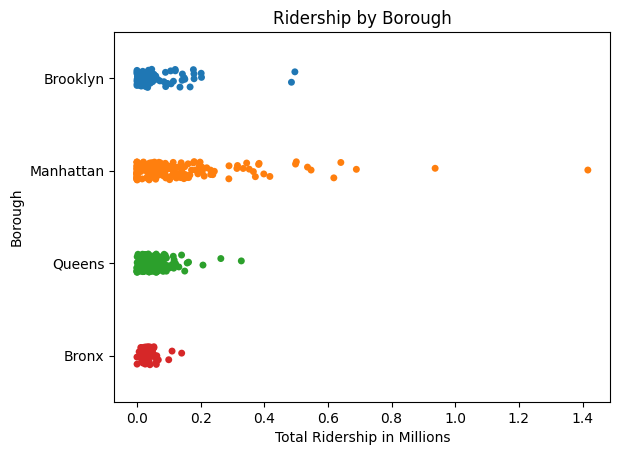

In [ ]:
# make a copy of by_station_df and divide the ridership by 1 Million to normalize the data to millions
by_station_df_normalize = by_station_df.copy()
by_station_df_normalize['ridership'] = by_station_df_normalize['ridership']/1000000

sns.stripplot(x=by_station_df_normalize['ridership'], y=by_station_df_normalize['borough'], hue=by_station_df_normalize['borough'])
plt.yticks([0, 1, 2, 3], [ 'Brooklyn', 'Manhattan', 'Queens', 'Bronx'])
plt.xlabel('Total Ridership in Millions')
plt.ylabel('Borough')
plt.title('Ridership by Borough')
plt.show()

Using a strip plot it allows us to see that each borough has a high concentration of stations with a low number of ridership. Each borough has a few stations with a much higher ridership than the rest, we can also see just how vast the difference is between the station at the rightmost and the rest of the stations.

Note : The right most station for Manhattan is Times-Square

ADA vs Non-ADA Stations across NYC

In [ ]:
fig = px.bar(
    result_reset,
    x='borough',
    y=['ADA Station Count', 'Non-ADA Station Count'],
    title='ADA vs Non-ADA Station Count by Borough',
    labels={'value': 'Station Count', 'borough': 'Borough'},
    text_auto=True,
    category_orders={'borough': ['Brooklyn', 'Manhattan', 'Queens', 'Bronx']}
)
fig.update_layout(barmode='group')
fig.show()

![](https://drive.google.com/uc?export=view&id=1JD_-3si2tNC6dnIPtwoZ8EfYFgrydN7M)


#### Fare Analysis

In [ ]:
# Calculate total ridership by fare class category
total_ridership_by_fare_class = hourly_ridership.groupby('fare_class_category')['ridership'].sum()

# Plot a bar chart for total ridership by fare class category
fig = px.bar(
    total_ridership_by_fare_class,
    x=total_ridership_by_fare_class.index,
    y=total_ridership_by_fare_class.values,
    title="Total Ridership by Fare Class Category",
    labels={'x': 'Fare Class Category', 'y': 'Total Ridership'},
    text_auto=True,
    color=total_ridership_by_fare_class.index
)
fig.show()

![](https://drive.google.com/uc?export=view&id=1OXegGvqbPKpa-2_bzW_HCLD7TA-V6KQc)


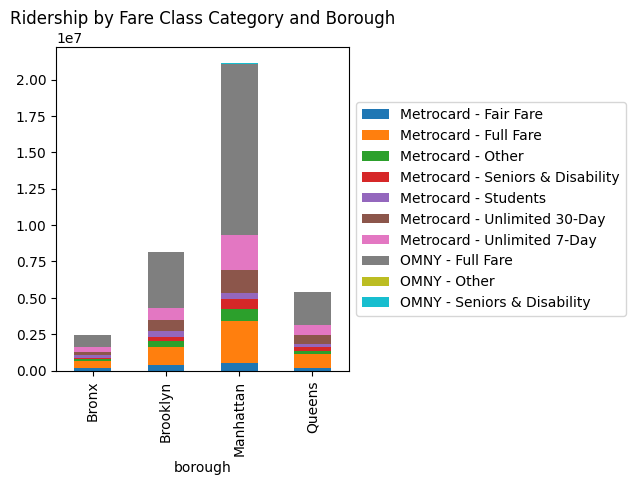

In [ ]:
# Group by borough and fare class category
borough_fare_class_ridership = hourly_ridership.groupby(['borough', 'fare_class_category'])['ridership'].sum().unstack()

# Ridership by borough and fare class category
ax = borough_fare_class_ridership.plot(kind='bar', stacked=True, title="Ridership by Fare Class Category and Borough")

# Move the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()  # Adjusts layout to avoid clipping of labels
plt.show()

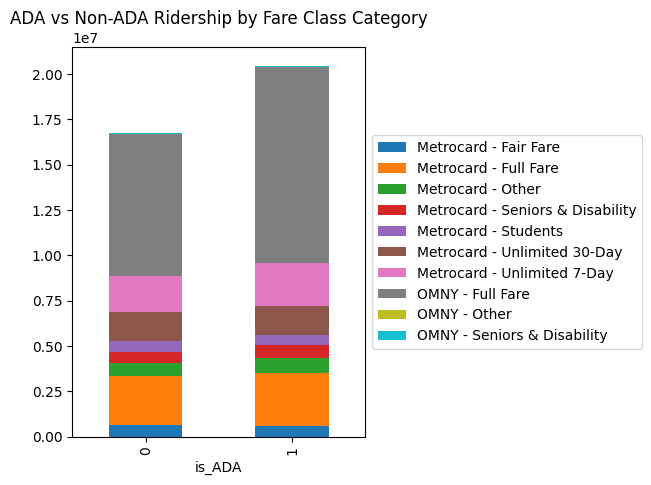

In [ ]:
# Group by ADA compliance and fare class category
ada_ridership_by_fare_class = hourly_ridership.groupby(['is_ADA', 'fare_class_category'])['ridership'].sum().unstack()

# Plot the ADA vs Non-ADA ridership by fare class
ax = ada_ridership_by_fare_class.plot(kind='bar', stacked=True, title="ADA vs Non-ADA Ridership by Fare Class Category")

# Move the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()

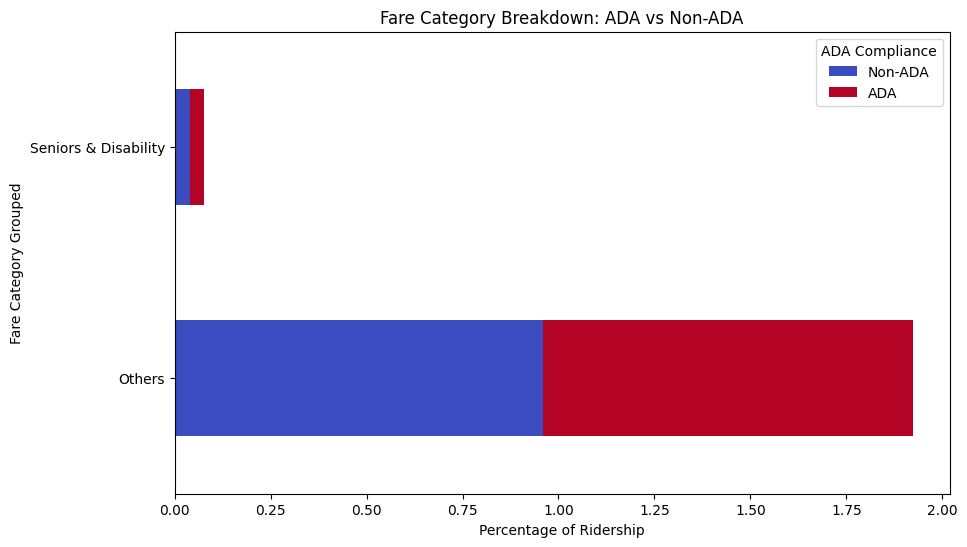

In [ ]:
# Combine categories into "Seniors & Disability" and "Others"
hourly_ridership['fare_category_grouped'] = hourly_ridership['fare_class_category'].apply(
    lambda x: 'Seniors & Disability' if 'Seniors & Disability' in x else 'Others'
)

# Group data by the new category and ADA compliance
fare_breakdown = hourly_ridership.groupby(['fare_category_grouped', 'is_ADA'])['ridership'].sum().unstack()

# Normalize percentages
fare_breakdown = fare_breakdown.div(fare_breakdown.sum(axis=0), axis=1)

# Plot the breakdown
fare_breakdown.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Fare Category Breakdown: ADA vs Non-ADA')
plt.xlabel('Percentage of Ridership')
plt.ylabel('Fare Category Grouped')
plt.legend(title='ADA Compliance', loc='best', labels=['Non-ADA', 'ADA'])
plt.show()

In [ ]:
# Count the number of entries for each fare class category
fare_class_count = hourly_ridership['fare_class_category'].value_counts()

# Plot the number of records by fare class category
fig = px.bar(
    fare_class_count,
    x=fare_class_count.index,
    y=fare_class_count.values,
    title="Number of Records by Fare Class Category",
    labels={'x': 'Fare Class Category', 'y': 'Record Count'},
    text_auto=True,
    color=total_ridership_by_fare_class.index
)
fig.show()

![](https://drive.google.com/uc?export=view&id=1yaOFFc1ivZLfraacw8NaTNHhRPXDyGWL)


#### Senior Citizen and Disabled Ridership Analysis

In [ ]:
# Filter data for the two fare classes
seniors_disability_ridership = hourly_ridership[
    hourly_ridership['fare_class_category'].isin(['Metrocard - Seniors & Disability', 'OMNY - Seniors & Disability'])
]

# Total ridership for both categories
total_ridership_by_fare_class = seniors_disability_ridership.groupby('fare_class_category')['ridership'].sum()
total_ridership_by_fare_class

fare_class_category
Metrocard - Seniors & Disability    1321619
OMNY - Seniors & Disability          108140
Name: ridership, dtype: int64

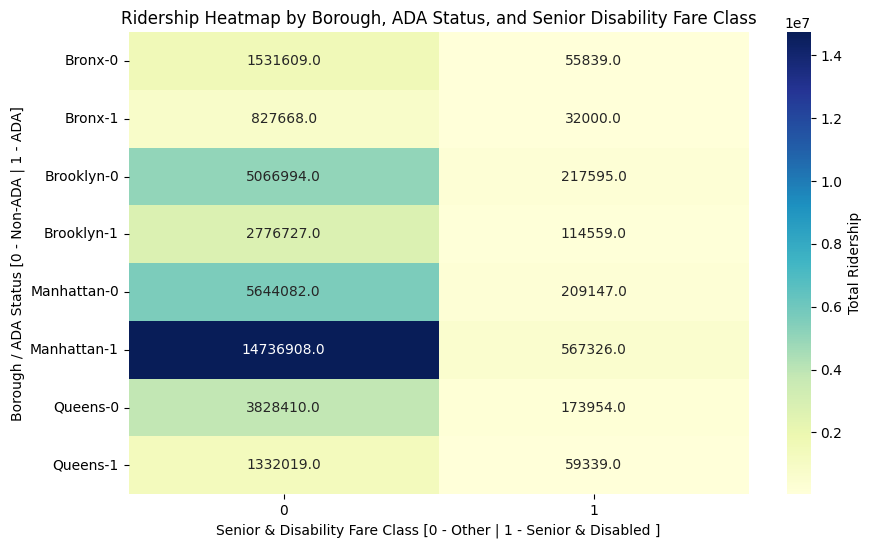

In [ ]:
# Group by borough, ADA status, and senior disability fare class
heatmap_data = hourly_ridership.groupby(['borough', 'is_ADA', 'is_senior_disabled'])['ridership'].sum().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", cbar_kws={'label': 'Total Ridership'})
plt.title('Ridership Heatmap by Borough, ADA Status, and Senior Disability Fare Class')
plt.xlabel('Senior & Disability Fare Class [0 - Other | 1 - Senior & Disabled ]')
plt.ylabel('Borough / ADA Status [0 - Non-ADA | 1 - ADA]')
plt.show()

- ADA-compliant ridership with senior/disabled fare class is significantly higher in Manhattan compared to other boroughs.
- Non-ADA ridership for the general population ("Other Fare Class") is relatively high across boroughs like Bronx and Manhattan.
- Brooklyn and Queens show more balanced ridership values across ADA statuses and fare classes.

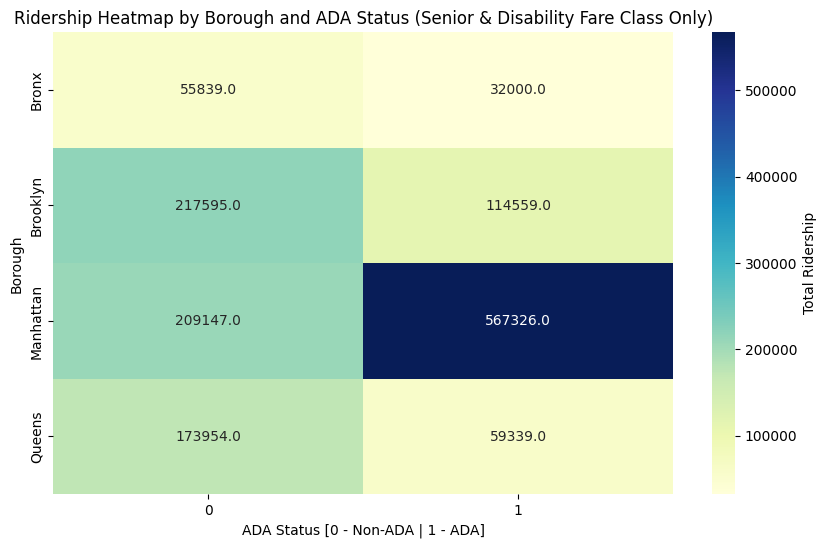

In [ ]:
# Filter for senior and disability fare class (is_senior_disabled = 1)
filtered_heatmap_data = hourly_ridership[hourly_ridership['is_senior_disabled'] == 1]

# Group by borough and ADA status for the filtered data
heatmap_data_filtered = filtered_heatmap_data.groupby(['borough', 'is_ADA'])['ridership'].sum().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_filtered, annot=True, cmap="YlGnBu", fmt=".1f", cbar_kws={'label': 'Total Ridership'})
plt.title('Ridership Heatmap by Borough and ADA Status (Senior & Disability Fare Class Only)')
plt.xlabel('ADA Status [0 - Non-ADA | 1 - ADA]')
plt.ylabel('Borough')
plt.show()

Analyzing top 10 stations with highest ridership by senior and Disabled people across ADA and non-ADA Stations

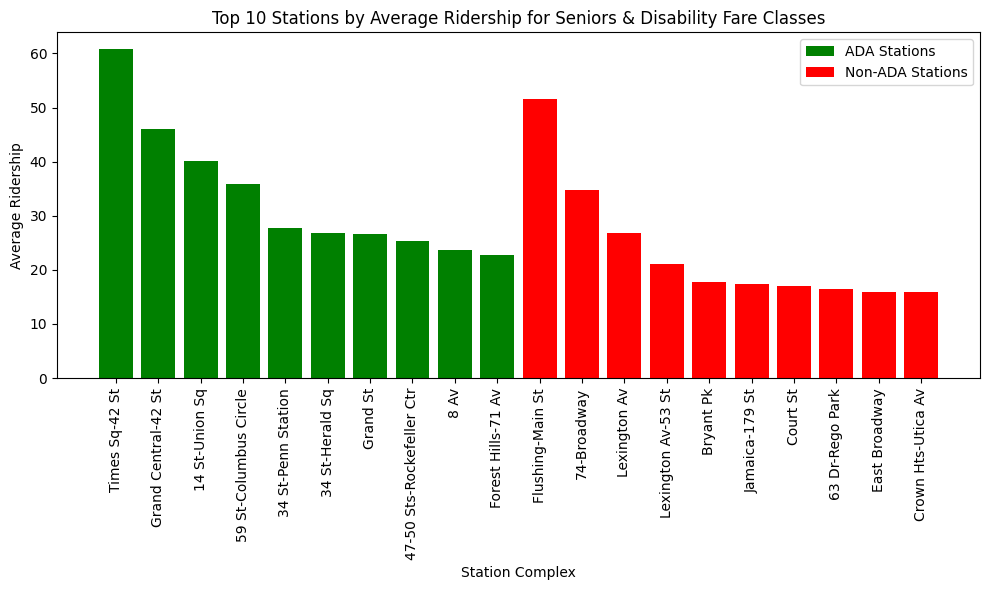

In [ ]:
avg_ridership_station = seniors_disability_ridership.groupby('station_complex')['ridership'].mean()

# Sort stations by average ridership
avg_ridership_station = avg_ridership_station.sort_values(ascending=False)

# Add 'is_ADA' information to the stations
avg_ridership_station = avg_ridership_station.reset_index()
avg_ridership_station['is_ADA'] = avg_ridership_station['station_complex'].apply(lambda x: hourly_ridership.loc[hourly_ridership['station_complex'] == x, 'is_ADA'].iloc[0])

# Plot top 10 stations by average ridership, with ADA and Non-ADA stations highlighted
fig, ax = plt.subplots(figsize=(10, 6))

# Separate ADA and Non-ADA stations
ada_stations = avg_ridership_station[avg_ridership_station['is_ADA'] == 1]
non_ada_stations = avg_ridership_station[avg_ridership_station['is_ADA'] == 0]

# Plot ADA stations with a color
ax.bar(ada_stations['station_complex'].head(10), ada_stations['ridership'].head(10), label='ADA Stations', color='green')

# Plot Non-ADA stations with a different color
ax.bar(non_ada_stations['station_complex'].head(10), non_ada_stations['ridership'].head(10), label='Non-ADA Stations', color='red')

# Add title and labels
ax.set_title("Top 10 Stations by Average Ridership for Seniors & Disability Fare Classes")
ax.set_xlabel("Station Complex")
ax.set_ylabel("Average Ridership")
ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Define the list of stations you're interested in
focus_list = ['Flushing-Main St', '74-Broadway', 'Lexington Av', 'Lexington Av-53 St', 'Bryant Pk',
              'Jamaica-179 St', 'Court St', '63 Dr-Rego Park', 'East Broadway', 'Crown Hts-Utica Av']

# Filter the hourly_ridership DataFrame to get rows for the focus stations
focus_stations_data = hourly_ridership[hourly_ridership['station_complex'].isin(focus_list)]

# Extract the relevant columns for focus stations
focus_stations_data_relevant_columns = focus_stations_data[['station_complex', 'routes', 'borough', 'ridership', 'transfers','is_ADA', 'is_senior_disabled']]

# Drop duplicates to avoid multiple rows for the same station
focus_stations_data_relevant_columns = focus_stations_data_relevant_columns.drop_duplicates()

# Display the relevant data for the focus stations
focus_stations_data_relevant_columns.head()

station_complex routes    borough  ridership  transfers  is_ADA  \
81             Court St      R   Brooklyn        274          3       0   
82             Court St      R   Brooklyn        772         14       0   
126  Crown Hts-Utica Av    3,4   Brooklyn         12          5       0   
155  Lexington Av-53 St    E,M  Manhattan        326          2       0   
209  Crown Hts-Utica Av    3,4   Brooklyn         18          1       0   

     is_senior_disabled  
81                    0  
82                    0  
126                   1  
155                   0  
209                   0

Finding Unique Route lines from the the 'routes' column

In [ ]:
# Split the routes into individual routes for stations with multiple routes
focus_stations_data_relevant_columns['routes'] = focus_stations_data_relevant_columns['routes'].str.split(',')

# Find unique routes
unique_routes = focus_stations_data_relevant_columns['routes'].explode().unique()
unique_routes

array(['R', '3', '4', 'E', 'M', '7', 'F', 'N', 'W', 'B', 'D'],
      dtype=object)

In [ ]:
focus_lines = ['R', '3', '4', 'E', 'M', '7', 'F', 'N', 'W', 'B', 'D']

Data from the previous Delays Notebook

In [ ]:
# Data for trains, riderships, delays, and ratio
data = {
    'trains': ['G', 'N', 'F', '2', 'A', 'E', 'Z', '6', 'Q', 'D', '1', '7', 'L', 'J', '4', '3', '5', 'C', 'R', 'M', 'B'],
    'riderships': [142053225, 424074446, 490856911, 458514533, 584843504, 498833386, 243697319, 611812922, 470605833,
                   463549728, 443331948, 393970074, 301013959, 274549932, 543062682, 378599110, 573453729, 651104459,
                   705498651, 475361270, 529358422],
    'delays': [57441, 166457, 147647, 131408, 159198, 130419, 57780, 144997, 110054, 108186, 101645, 83958, 63590,
               57780, 105746, 69582, 77524, 82866, 85889, 56105, 60961],
    'ratio': [0.000404, 0.000393, 0.000301, 0.000287, 0.000272, 0.000261, 0.000237, 0.000237, 0.000234, 0.000233,
              0.000229, 0.000213, 0.000211, 0.000210, 0.000195, 0.000184, 0.000135, 0.000127, 0.000122, 0.000118, 0.000115]
}

# Creating the DataFrame
trains_delay = pd.DataFrame(data)

# Display the DataFrame
trains_delay

trains  riderships  delays     ratio
0       G   142053225   57441  0.000404
1       N   424074446  166457  0.000393
2       F   490856911  147647  0.000301
3       2   458514533  131408  0.000287
4       A   584843504  159198  0.000272
5       E   498833386  130419  0.000261
6       Z   243697319   57780  0.000237
7       6   611812922  144997  0.000237
8       Q   470605833  110054  0.000234
9       D   463549728  108186  0.000233
10      1   443331948  101645  0.000229
11      7   393970074   83958  0.000213
12      L   301013959   63590  0.000211
13      J   274549932   57780  0.000210
14      4   543062682  105746  0.000195
15      3   378599110   69582  0.000184
16      5   573453729   77524  0.000135
17      C   651104459   82866  0.000127
18      R   705498651   85889  0.000122
19      M   475361270   56105  0.000118
20      B   529358422   60961  0.000115

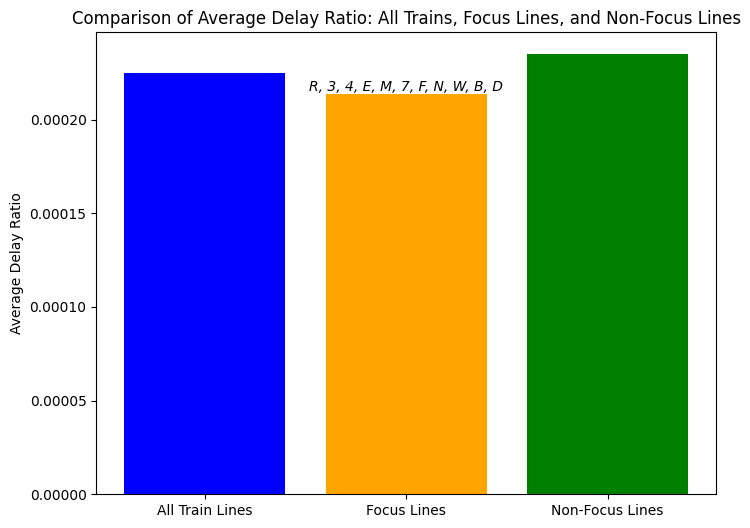

Average Delay Ratio (All Trains): 0.000225
Average Delay Ratio (Focus Lines): 0.000213
Average Delay Ratio (Non-Focus Lines): 0.000235


In [ ]:
# Filter for focus lines
focus_trains_delay = trains_delay[trains_delay['trains'].isin(focus_lines)]

# Filter for non-focus lines (all lines except the focus lines)
non_focus_trains_delay = trains_delay[~trains_delay['trains'].isin(focus_lines)]

# Calculate the average delay ratio for all trains, focus lines, and non-focus lines
avg_delay_ratio_all = trains_delay['ratio'].mean()
avg_delay_ratio_focus = focus_trains_delay['ratio'].mean()
avg_delay_ratio_non_focus = non_focus_trains_delay['ratio'].mean()

# Plot the comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(['All Train Lines', 'Focus Lines', 'Non-Focus Lines'],
               [avg_delay_ratio_all, avg_delay_ratio_focus, avg_delay_ratio_non_focus],
               color=['blue', 'orange', 'green'])

# Annotate the graph with focus lines information
plt.text(1, avg_delay_ratio_focus + 0.000002, ', '.join(focus_lines),
         horizontalalignment='center', fontsize=10, color='black', style='italic')

plt.ylabel('Average Delay Ratio')
plt.title('Comparison of Average Delay Ratio: All Trains, Focus Lines, and Non-Focus Lines')

# Show the plot
plt.show()

# Print the average delay ratios
print(f"Average Delay Ratio (All Trains): {avg_delay_ratio_all:.6f}")
print(f"Average Delay Ratio (Focus Lines): {avg_delay_ratio_focus:.6f}")
print(f"Average Delay Ratio (Non-Focus Lines): {avg_delay_ratio_non_focus:.6f}")

We can observe that the delays_ratio in Lines of the top 10 Non-ADA stations travelled by Senior & Disabled people is less compared to other lines and overall delay_ratio. Which means accessibility in terms of delay in these atations are pretty good.

Ridership by day of the week

In [ ]:
## make a new column called day_of_week using the transit_timestamp column
hourly_ridership['day_of_week'] = hourly_ridership['transit_timestamp'].dt.day_name()

In [ ]:
# Extract the date part from the datetime values and assign to a new column
hourly_ridership.loc[:, 'date_only'] = hourly_ridership['transit_timestamp'].dt.date

# Get the count of unique calendar days
unique_days_count = hourly_ridership['date_only'].nunique()

# Display the result
print("Count of unique calendar days:", unique_days_count)

Count of unique calendar days: 213


In [ ]:
by_day = hourly_ridership.groupby(['day_of_week'])['ridership'].sum().reset_index()
print(by_day.shape)
by_day.head()

(7, 2)


day_of_week  ridership
0      Friday     847501
1      Monday    7249735
2    Saturday    7416687
3      Sunday    6689926
4    Thursday    2882140

Reorder the dates by setting a list of days

In [ ]:
lst = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
by_day["day_of_week"] = pd.Categorical(by_day["day_of_week"], categories=lst, ordered=True)

# Sort the DataFrame based on the custom order of the 'day_of_week' column
by_day = by_day.sort_values("day_of_week")

# Reset the index if needed
by_day = by_day.reset_index(drop=True)
by_day

day_of_week  ridership
0      Monday    7249735
1     Tuesday    9019725
2   Wednesday    3068462
3    Thursday    2882140
4      Friday     847501
5    Saturday    7416687
6      Sunday    6689926

average ridership per day

In [ ]:
by_day['ridership_per_day'] = by_day['ridership'] / 213
by_day

day_of_week  ridership  ridership_per_day
0      Monday    7249735       34036.314554
1     Tuesday    9019725       42346.126761
2   Wednesday    3068462       14405.924883
3    Thursday    2882140       13531.173709
4      Friday     847501        3978.877934
5    Saturday    7416687       34820.126761
6      Sunday    6689926       31408.103286

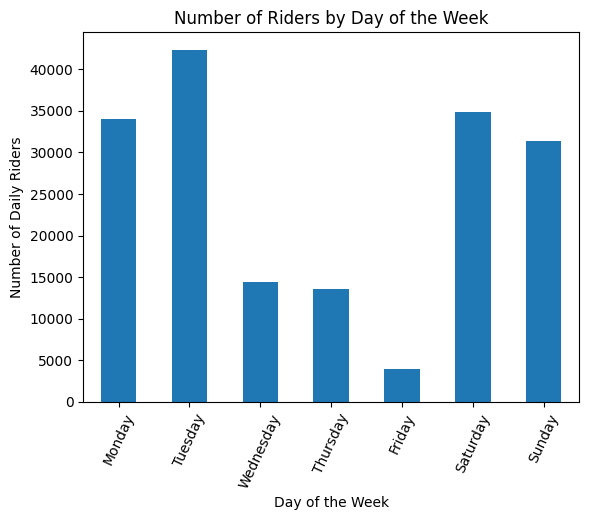

In [ ]:
## plot just the ridership_per_day
by_day['ridership_per_day'].plot(kind='bar')
## name the plot
plt.title('Number of Riders by Day of the Week')
## label the x-axis with day_of_the_week
## change the x-axis to be the day of the week
## make xticks angled
plt.xlabel('Day of the Week')
plt.ylabel('Number of Daily Riders')
plt.xticks(rotation=45)
plt.xticks(range(7), lst, rotation=65)
plt.show()

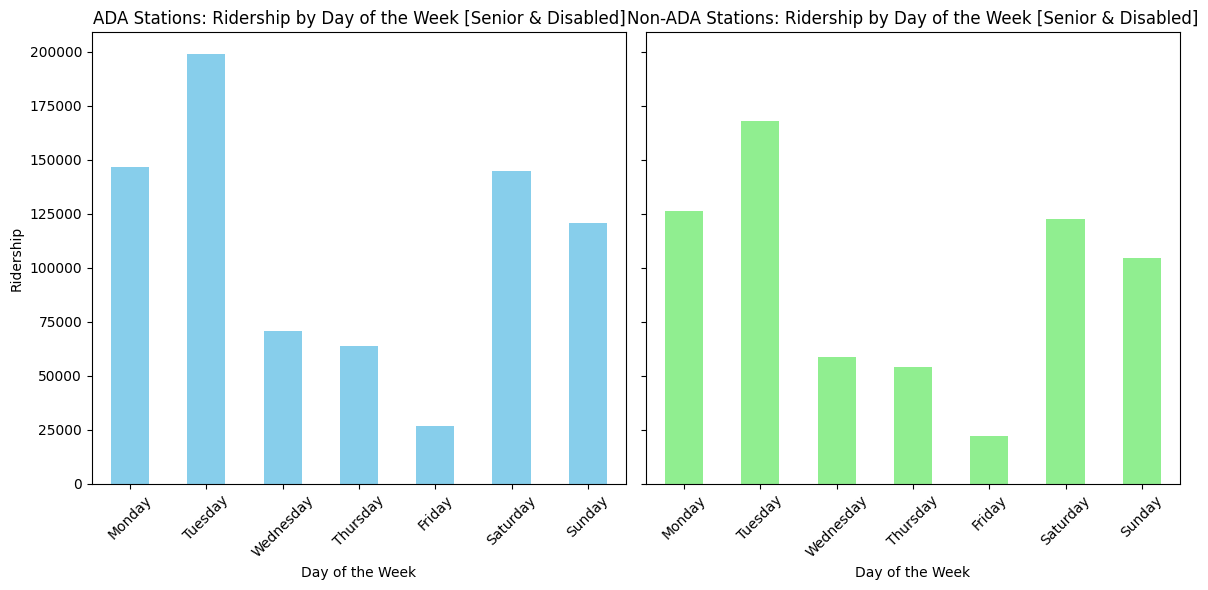

In [ ]:
# Filter for senior and disabled ridership data
senior_disabled_data = hourly_ridership[hourly_ridership['is_senior_disabled'] == 1]

# Filter for ADA stations and Non-ADA stations
ada_stations = senior_disabled_data[senior_disabled_data['is_ADA'] == 1]
non_ada_stations = senior_disabled_data[senior_disabled_data['is_ADA'] == 0]

# Group by day_of_week and sum the ridership for both ADA and Non-ADA stations
ada_by_day = ada_stations.groupby(['day_of_week'])['ridership'].sum().reset_index()
non_ada_by_day = non_ada_stations.groupby(['day_of_week'])['ridership'].sum().reset_index()

# Set day_of_week to a categorical type with the correct order
lst = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ada_by_day["day_of_week"] = pd.Categorical(ada_by_day["day_of_week"], categories=lst, ordered=True)
non_ada_by_day["day_of_week"] = pd.Categorical(non_ada_by_day["day_of_week"], categories=lst, ordered=True)

# Sort by day_of_week
ada_by_day = ada_by_day.sort_values("day_of_week")
non_ada_by_day = non_ada_by_day.sort_values("day_of_week")

# Create the plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for ADA stations
ada_by_day['ridership'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('ADA Stations: Ridership by Day of the Week [Senior & Disabled]')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Ridership')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(lst, rotation=45)

# Plot for Non-ADA stations
non_ada_by_day['ridership'].plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Non-ADA Stations: Ridership by Day of the Week [Senior & Disabled]')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Ridership')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(lst, rotation=45)

# Adjust layout to make room for labels
plt.tight_layout()

# Show the plot
plt.show()

We can see that the middle of the work week tends to have the highest number of riders, with a significant decrease on the weekends. We can create a similar visualization to see the ridership by month

In [ ]:
hourly_ridership.loc[:, 'month_only'] = hourly_ridership['transit_timestamp'].dt.month

by_month = hourly_ridership.groupby(['month_only'])['ridership'].sum().reset_index()
by_month['ridership_per_month'] = (by_month['ridership'] / 12).round().astype(int)
by_month.head()

month_only  ridership  ridership_per_month
0           1    9397887               783157
1           2    1774976               147915
2           3      68023                 5669
3           4     297870                24822
4           5     451893                37658

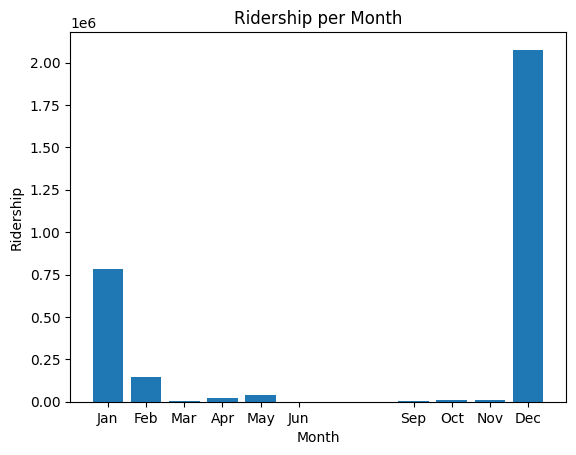

In [ ]:
plt.bar(by_month['month_only'], by_month['ridership_per_month'])
plt.xlabel('Month')
plt.ylabel('Ridership')
plt.title('Ridership per Month')
plt.xticks(by_month['month_only'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Sep', 'Oct','Nov', 'Dec'])
plt.show()

We see a large decrease in february and following months. This is likely due to February only having 28 days and July and August being the summer months which would correlate with vacation frequency.

<ipython-input-65-559e7cdedf7e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'Ridership Trends for Seniors & Disability Fare Classes (Metrocard & OMNY)'}, xlabel='transit_timestamp'>

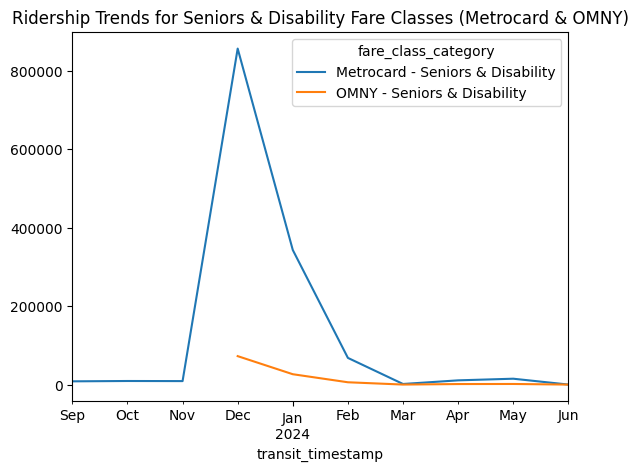

In [ ]:
# Convert 'transit_timestamp' to datetime if not already
seniors_disability_ridership['transit_timestamp'] = pd.to_datetime(seniors_disability_ridership['transit_timestamp'])

# Group by month and fare class
monthly_ridership = seniors_disability_ridership.groupby([seniors_disability_ridership['transit_timestamp'].dt.to_period('M'), 'fare_class_category'])['ridership'].sum().unstack()

# Plot the ridership trend over time
monthly_ridership.plot(title="Ridership Trends for Seniors & Disability Fare Classes (Metrocard & OMNY)")

Number of Riders by hour

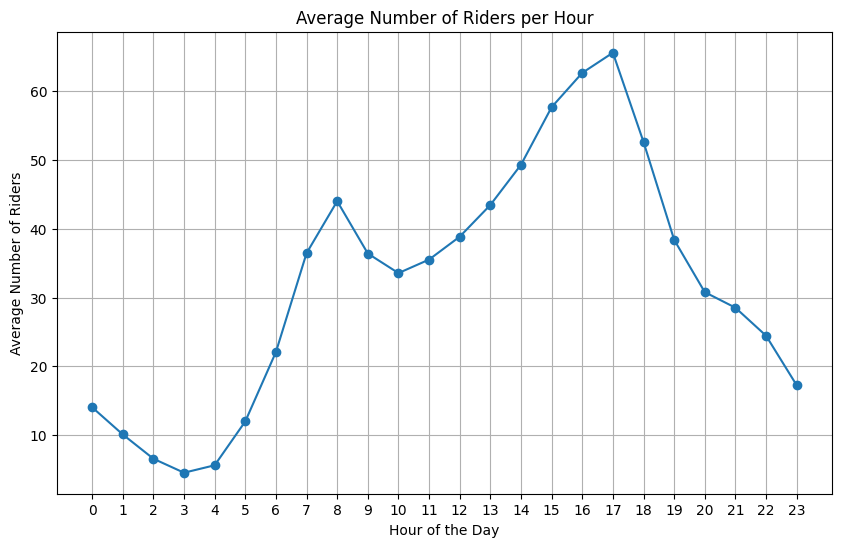

In [ ]:
# Step 3: Extract the hour from 'transit_timestamp'
hourly_ridership['hour'] = hourly_ridership['transit_timestamp'].dt.hour

# Step 4: Calculate the average number of riders for each hour
average_riders_per_hour = hourly_ridership.groupby('hour')['ridership'].mean()

# Step 5: Plot the data on a graph
plt.figure(figsize=(10, 6))
plt.plot(average_riders_per_hour.index, average_riders_per_hour.values, marker='o', linestyle='-')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Riders')
plt.title('Average Number of Riders per Hour')
plt.xticks(average_riders_per_hour.index)
plt.grid(True)
plt.show()

<ipython-input-67-de92b51d719c>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-67-de92b51d719c>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



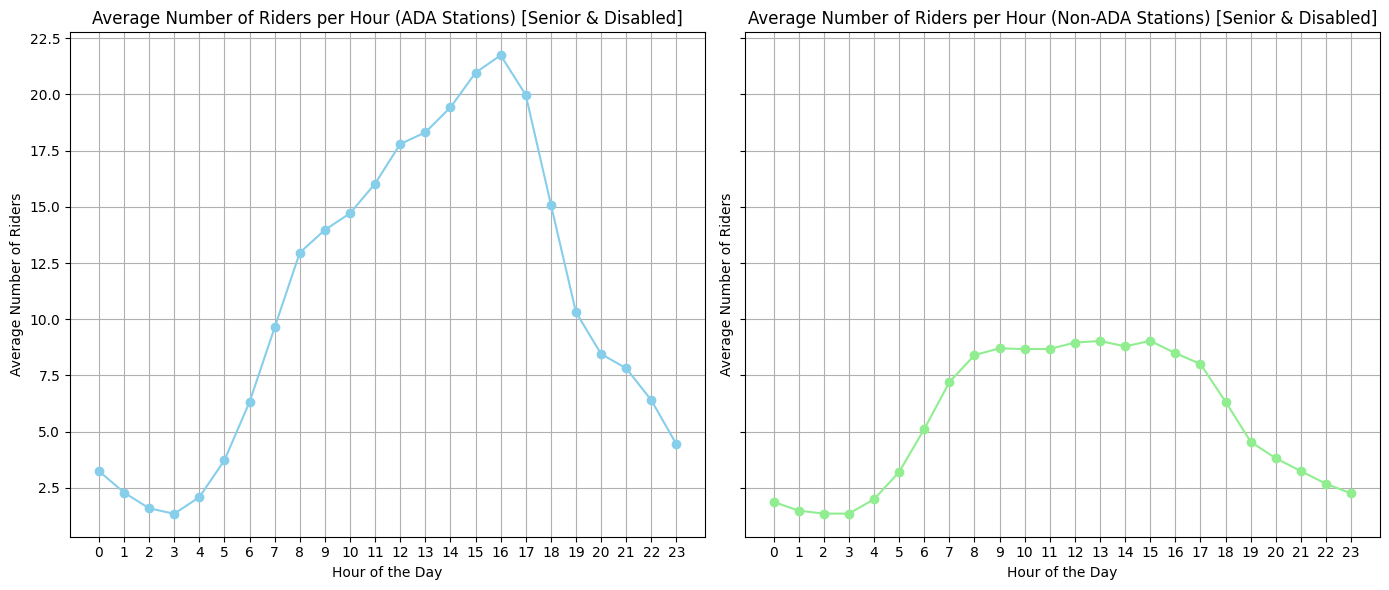

In [ ]:
# Filter for senior and disabled ridership data
senior_disabled_data = hourly_ridership[hourly_ridership['is_senior_disabled'] == 1]

# Filter for ADA stations and Non-ADA stations
ada_stations = senior_disabled_data[senior_disabled_data['is_ADA'] == 1]
non_ada_stations = senior_disabled_data[senior_disabled_data['is_ADA'] == 0]

# Step 3: Extract the hour from 'transit_timestamp'
ada_stations['hour'] = ada_stations['transit_timestamp'].dt.hour
non_ada_stations['hour'] = non_ada_stations['transit_timestamp'].dt.hour

# Step 4: Calculate the average number of riders for each hour for ADA stations and Non-ADA stations
average_riders_ada = ada_stations.groupby('hour')['ridership'].mean()
average_riders_non_ada = non_ada_stations.groupby('hour')['ridership'].mean()

# Step 5: Plot the data on a graph
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for ADA stations
axes[0].plot(average_riders_ada.index, average_riders_ada.values, marker='o', linestyle='-', color='skyblue')
axes[0].set_title('Average Number of Riders per Hour (ADA Stations) [Senior & Disabled]')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Average Number of Riders')
axes[0].set_xticks(range(0, 24, 1))
axes[0].grid(True)

# Plot for Non-ADA stations
axes[1].plot(average_riders_non_ada.index, average_riders_non_ada.values, marker='o', linestyle='-', color='lightgreen')
axes[1].set_title('Average Number of Riders per Hour (Non-ADA Stations) [Senior & Disabled]')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Average Number of Riders')
axes[1].set_xticks(range(0, 24, 1))
axes[1].grid(True)

# Adjust layout to make room for labels
plt.tight_layout()

# Show the plot
plt.show()

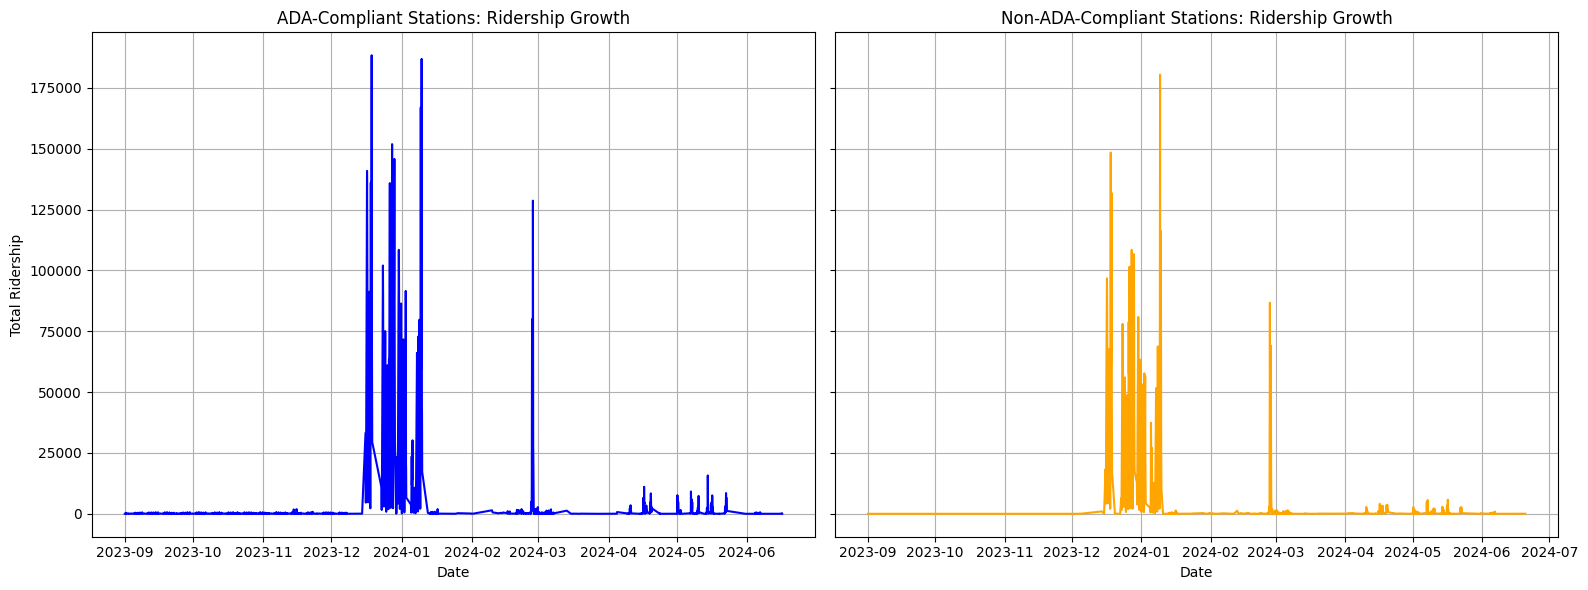

In [ ]:
# Convert transit_timestamp to datetime if not already done
hourly_ridership['date'] = pd.to_datetime(hourly_ridership['transit_timestamp'])

# Separate ADA and non-ADA compliant data
ada_ridership = hourly_ridership[hourly_ridership['is_ADA'] == 1]
non_ada_ridership = hourly_ridership[hourly_ridership['is_ADA'] == 0]

# Calculate ridership growth over time for ADA and non-ADA stations
ada_growth = ada_ridership.groupby('date')['ridership'].sum()
non_ada_growth = non_ada_ridership.groupby('date')['ridership'].sum()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot ADA ridership growth
axes[0].plot(ada_growth.index, ada_growth.values, color='blue')
axes[0].set_title('ADA-Compliant Stations: Ridership Growth')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Ridership')
axes[0].grid(True)

# Plot Non-ADA ridership growth
axes[1].plot(non_ada_growth.index, non_ada_growth.values, color='orange')
axes[1].set_title('Non-ADA-Compliant Stations: Ridership Growth')
axes[1].set_xlabel('Date')
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Most popular stations

Popularity based by average ridership

In [ ]:
top_10_stations = by_station_df.sort_values(by=['ridership'], ascending=False).head(10)
top_10_stations

station_complex_id            station_complex  is_ADA    borough  \
388                611             Times Sq-42 St       1  Manhattan   
382                610        Grand Central-42 St       1  Manhattan   
361                602             14 St-Union Sq       1  Manhattan   
375                607            34 St-Herald Sq       1  Manhattan   
52                 164         34 St-Penn Station       1  Manhattan   
440                628                  Fulton St       1  Manhattan   
394                614      59 St-Columbus Circle       1  Manhattan   
110                225  47-50 Sts-Rockefeller Ctr       1  Manhattan   
194                318         34 St-Penn Station       1  Manhattan   
400                616                74-Broadway       0     Queens   

      latitude  longitude  ridership  
388  40.757310 -73.986755    1416618  
382  40.751778 -73.976845     936801  
361  40.735737 -73.989950     689337  
375  40.749718 -73.987820     640573  
52   40.752290 -73.993390     618521  
440  40.710373 -74.006570     547034  
394  40.768295 -73.981735     535833  
110  40.758663 -73.981330     500697  
194  40.750374 -73.991060     498254  
400  40.746850 -73.891335     496155

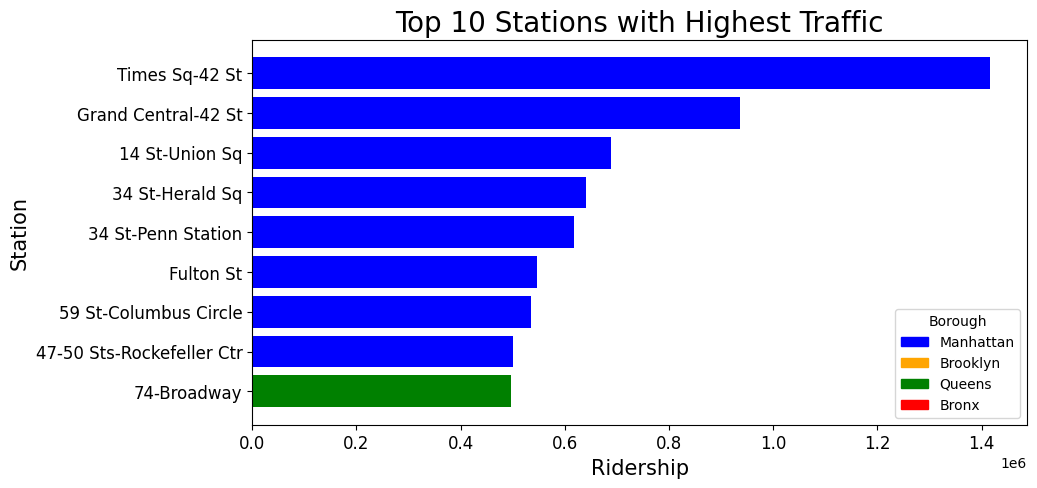

In [ ]:
# Borough colors
borough_colors = {'Manhattan': 'blue', 'Brooklyn': 'orange', 'Queens': 'green', 'Bronx': 'red'}

plt.figure(figsize=(10, 5))

# Plot each bar separately with the specified color
for i, station in enumerate(top_10_stations['station_complex']):
    plt.barh(station, top_10_stations['ridership'].iloc[i], color=borough_colors[top_10_stations['borough'].iloc[i]])

plt.title('Top 10 Stations with Highest Traffic', fontsize=20)
plt.xlabel('Ridership', fontsize=15)
plt.ylabel('Station', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

# Create custom legend for borough colors
handles = [plt.Rectangle((0, 0), 1, 1, color=borough_colors[borough]) for borough in borough_colors]
labels = list(borough_colors.keys())
plt.legend(handles, labels, title='Borough')

plt.show()

How much usage do the top 10 stations account for?

In [ ]:
## sum of all ridership in by_station_df
# by_station_df['total_ridership'] = by_station_df['ridership'].sum(axis=1)
total_ridership = by_station_df['ridership'].sum()
top_10_ridership = top_10_stations['ridership'].sum()

In [ ]:
percentage_of_ridership_from_top10 = top_10_ridership / total_ridership * 100
print(f"Percentage of total ridership from the 10 most popular stations: {percentage_of_ridership_from_top10:.2f}%")

## get total number of rows in the dataframe
stations_total = len(by_station_df)
print(f"These 10 stations only account for {((10/stations_total)*100):.2f}% of the total number of stations")

Percentage of total ridership from the 10 most popular stations: 18.51%
These 10 stations only account for 2.06% of the total number of stations


### 4. Geographical Visualization

In [ ]:
by_station_df['ridership_per_day'] = by_station_df['ridership'] / 365
# round ridership_per_day to a whole number
by_station_df['ridership_per_day'] = by_station_df['ridership_per_day'].round(0)

In [ ]:
# new column called scaled_marker_size with a number that is a fraction of ridership_per_day
# this new column will be used to display a normalized marker size for ridership
by_station_df['scaled_marker_size'] = by_station_df['ridership_per_day'] / by_station_df['ridership_per_day'].max() * 75

# round scaled_marker-size to 4 decimal places
by_station_df['scaled_marker_size'] = by_station_df['scaled_marker_size'].round(4)

# new column called locked_marker_size with a value of 1
# this will lock the lowest marker size to 1
by_station_df['locked_marker_size'] = 1
by_station_df.head()

station_complex_id       station_complex  is_ADA    borough   latitude  \
0                  1  Astoria-Ditmars Blvd       0     Queens  40.775036   
1                 10                 49 St       1  Manhattan  40.759900   
2                100              Hewes St       0   Brooklyn  40.706870   
3                101              Marcy Av       1   Brooklyn  40.708360   
4                103                Bowery       0  Manhattan  40.720280   

   longitude  ridership  ridership_per_day  scaled_marker_size  \
0 -73.912030     107301              294.0              5.6815   
1 -73.984140     231826              635.0             12.2713   
2 -73.953430      17902               49.0              0.9469   
3 -73.957756      81379              223.0              4.3095   
4 -73.993910      32585               89.0              1.7199   

   locked_marker_size  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1

In [ ]:
bins = [161.55, 10000, 50000, 75000, 135546]
bin_labels = [
    'Low (161 - 10000)',
    'Medium (10,000 - 50,000)',
    'High (50,000 - 75,000)',
    'Very High (75,000+)'
]

# Create a dictionary to map bin labels to colors
bin_colors = {
    'Low (161 - 10000)': 'rgb(255, 195, 0)',
    'Medium (10,000 - 50,000)': 'rgb(255, 87, 51)',
    'High (50,000 - 75,000)': 'rgb(199, 0, 57)',
    'Very High (75,000+)': 'rgb(88, 24, 69)'
}
by_station_df['ridership_bin'] = pd.cut(by_station_df['ridership_per_day'], bins=bins, labels=bin_labels)

In [ ]:
# reorder by_station_df to do the highest ridership_per_day to lowest ridership_per_day
by_station_df = by_station_df.sort_values(by=['ridership_per_day'], ascending=False)

by_station_df = by_station_df.reset_index(drop=True)
by_station_df.head()

station_complex_id      station_complex  is_ADA    borough   latitude  \
0                611       Times Sq-42 St       1  Manhattan  40.757310   
1                610  Grand Central-42 St       1  Manhattan  40.751778   
2                602       14 St-Union Sq       1  Manhattan  40.735737   
3                607      34 St-Herald Sq       1  Manhattan  40.749718   
4                164   34 St-Penn Station       1  Manhattan  40.752290   

   longitude  ridership  ridership_per_day  scaled_marker_size  \
0 -73.986755    1416618             3881.0             75.0000   
1 -73.976845     936801             2567.0             49.6071   
2 -73.989950     689337             1889.0             36.5048   
3 -73.987820     640573             1755.0             33.9152   
4 -73.993390     618521             1695.0             32.7557   

   locked_marker_size      ridership_bin  
0                   1  Low (161 - 10000)  
1                   1  Low (161 - 10000)  
2                   1  Low (161 - 10000)  
3                   1  Low (161 - 10000)  
4                   1  Low (161 - 10000)

In [ ]:
# Set base map with folium
m_2 = folium.Map(location=[40.75, -73.9], tiles='cartodbpositron', zoom_start=11)

# Prepare data for heatmap (convert latitude and longitude to a list of points)
heat_data = [[point.xy[1][0], point.xy[0][0], ridership] for point, ridership in zip(geo_stations_df.geometry, geo_stations_df.ridership)]

# Create the HeatMap
HeatMap(
    data=heat_data,
    radius=15,
    blur=10,
).add_to(m_2)

# Display the map
m_2

### 5. Predicting Ridership

If we can create a model to predict ridership at any given time, this would be an incredibly useful tool for the MTA to use. This would allow them to better plan for maintenance, staffing, and other resources. This data set is limited to only a few factors that could affect ridership, but it is a good starting point and will indicate if it is possible to create a model to predict ridership.

chose to use Random Forest Regression for this task because we needed to choose a model that can handle non-linear data and it is not prone to overfitting.

In [ ]:
# make a new dataframe called rfr_df
rfr_df = pd.DataFrame()

In [ ]:
rfr_df['month'] = original_df['transit_timestamp'].dt.month
rfr_df['day'] = original_df['transit_timestamp'].dt.day
rfr_df['hour'] = original_df['transit_timestamp'].dt.hour
rfr_df['ridership'] = original_df['ridership']

rfr_df = rfr_df.groupby(['month', 'day', 'hour'])['ridership'].sum().reset_index()

rfr_df.head()

month  day  hour  ridership
0      1    1     0        860
1      1    1     1      58531
2      1    1     2      37612
3      1    1     3      18512
4      1    1     4      12243

In [ ]:
X = rfr_df[['month', 'day', 'hour']]
y = rfr_df['ridership']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Absolute Error: 1797.23 riders.
R-squared (R2): 0.96
Accuracy: -336.44 %.


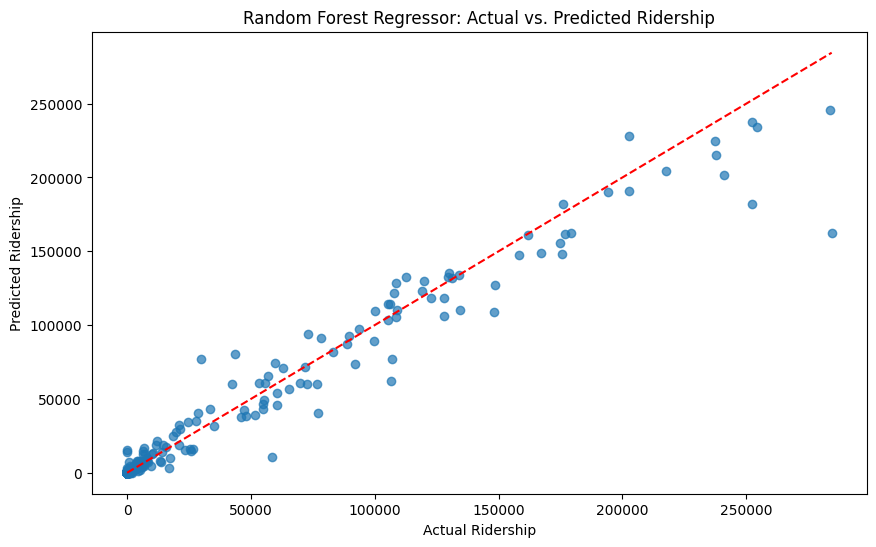

In [ ]:
# Split the data into features and labels
labels = np.array(rfr_df['ridership'])
features = rfr_df.drop('ridership', axis=1)
feature_list = list(features.columns)
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=38
)

# Instantiate model with decision trees
rf = RandomForestRegressor(n_estimators=400, random_state=38)

# Train the model on training data
rf.fit(train_features, train_labels)

# Make predictions on the test set
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (MAE)
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'riders.')

# Calculate the R-squared (R2)
r2 = r2_score(test_labels, predictions)
print('R-squared (R2):', round(r2, 2))

# Calculate and display Mean Absolute Percentage Error (MAPE) and Accuracy
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Create a scatter plot to visualize the predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.7)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')

plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Random Forest Regressor: Actual vs. Predicted Ridership')
plt.show()

We can see we got an impressive R2 score of 0.88. This indicates that our model has potential to fit the data. This was only based on three factors. Unfortunately, the model has a mean absolute error of around 32 thousand. However if more factors were added to the model, it could potentially be improved, such as weather, unique stations, holidays, etc.

month: 0.2976670438709559
day: 0.3967444957183227
hour: 0.3055884604107214


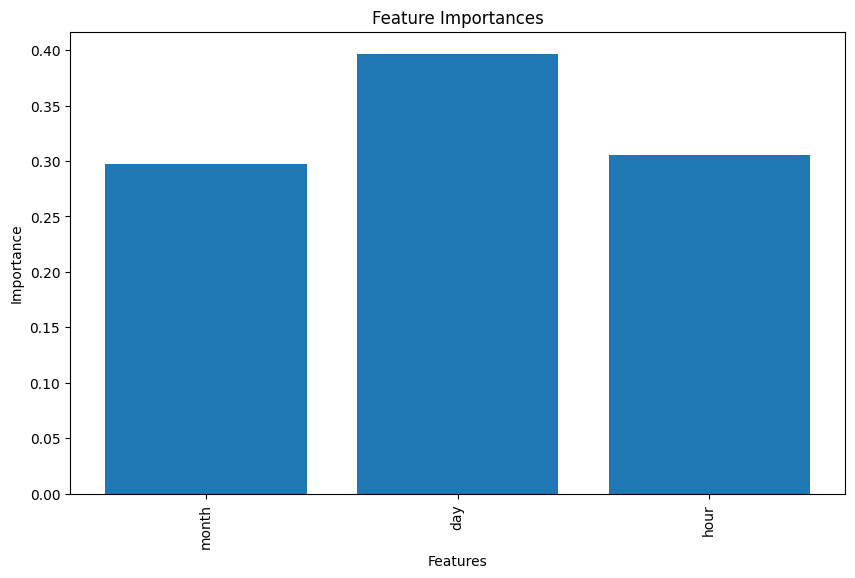

In [ ]:
# Train the model on training data
rf.fit(train_features, train_labels)

# Get feature importances
feature_importances = rf.feature_importances_

# Associate feature importances with feature names
feature_importance_list = list(zip(feature_list, feature_importances))

# Print the top N most important features and their importances
for feature, importance in feature_importance_list:
    print(f"{feature}: {importance}")

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), [feature[0] for feature in feature_importance_list], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
def predict_and_show_ridership(month, day, hour):
    input_data = np.array([[month, day, hour]])
    predicted_ridership = rf.predict(input_data)
    actual_ridership = rfr_df[(rfr_df['month'] == month) & (rfr_df['day'] == day) & (rfr_df['hour'] == hour)]['ridership'].values[0]

    print(f"Input: Month={month}, Day={day}, Hour={hour}")
    print(f"Predicted Ridership: {round(predicted_ridership[0], 2)}")
    print(f"Actual Ridership: {actual_ridership}")

In [ ]:
# Test the function with a specific input
predict_and_show_ridership(month=1, day=5, hour=12)

Input: Month=1, Day=5, Hour=12
Predicted Ridership: 31357.94
Actual Ridership: 31102


In [ ]:
predict_and_show_ridership(month=12, day=27, hour=2)

Input: Month=12, Day=27, Hour=2
Predicted Ridership: 5190.99
Actual Ridership: 4865


# Disability Analysis


### 1. Load Dataset


In [ ]:
disability_zip_dat = pd.read_csv('/content/mta-nyc-dataset/ACSST5Y2022.S1810-Data.csv', encoding='latin1')
nyc_zips = pd.read_csv('/content/mta-nyc-dataset/nyc_zip.csv')
stations_ADA = pd.read_csv("/content/mta-nyc-dataset/MTA_Subway_Stations_ADA.csv")
MTA_Feedback_Data = pd.read_csv("/content/mta-nyc-dataset/MTA_Feedback.csv")
accessibility = pd.read_csv("/content/mta-nyc-dataset/MTA_Accessibility.csv")

### 2. Exploring the Datasets

In [ ]:
print(f"Disability Zip Data Shape: {disability_zip_dat.shape}")
disability_zip_dat.head(3)

Disability Zip Data Shape: (1827, 417)


ÿ"GEO_ID"                  NAME  \
0       Geography  Geographic Area Name   
1  860Z200US06390           ZCTA5 06390   
2  860Z200US10001           ZCTA5 10001   

                                      S1810_C01_001E  \
0  Estimate!!Total!!Total civilian noninstitution...   
1                                                 53   
2                                              27004   

                                      S1810_C01_001M  \
0  Margin of Error!!Total!!Total civilian noninst...   
1                                                 39   
2                                               1827   

                                      S1810_C01_002E  \
0  Estimate!!Total!!Total civilian noninstitution...   
1                                                 33   
2                                              12679   

                                      S1810_C01_002M  \
0  Margin of Error!!Total!!Total civilian noninst...   
1                                                 24   
2                                               1103   

                                      S1810_C01_003E  \
0  Estimate!!Total!!Total civilian noninstitution...   
1                                                 20   
2                                              14325   

                                      S1810_C01_003M  \
0  Margin of Error!!Total!!Total civilian noninst...   
1                                                 20   
2                                               1294   

                                      S1810_C01_004E  \
0  Estimate!!Total!!Total civilian noninstitution...   
1                                                 33   
2                                              15428   

                                      S1810_C01_004M  ...  \
0  Margin of Error!!Total!!Total civilian noninst...  ...   
1                                                 33  ...   
2                                               1696  ...   

                                      S1810_C03_065M  \
0  Margin of Error!!Percent with a disability!!To...   
1                                               84.9   
2                                                0.3   

                                      S1810_C03_066E  \
0  Estimate!!Percent with a disability!!Total civ...   
1                                               25.0   
2                                                1.7   

                                      S1810_C03_066M  \
0  Margin of Error!!Percent with a disability!!To...   
1                                               52.9   
2                                                1.0   

                                      S1810_C03_067E  \
0  Estimate!!Percent with a disability!!Total civ...   
1                                                  -   
2                                               15.7   

                                      S1810_C03_067M  \
0  Margin of Error!!Percent with a disability!!To...   
1                                                 **   
2                                                6.0   

                                      S1810_C03_068E  \
0  Estimate!!Percent with a disability!!Total civ...   
1                                                  -   
2                                                4.1   

                                      S1810_C03_068M  \
0  Margin of Error!!Percent with a disability!!To...   
1                                                 **   
2                                                3.7   

                                      S1810_C03_069E  \
0  Estimate!!Percent with a disability!!Total civ...   
1                                                  -   
2                                               27.7   

                                      S1810_C03_069M Unnamed: 416  
0  Margin of Error!!Percent with a disability!!To...          NaN  
1                                                 **          NaN  
2          

In [ ]:
print(f"NYC Zips Shape: {nyc_zips.shape}")
nyc_zips.head(3)

NYC Zips Shape: (178, 3)


Borough   Neighborhood  ZipCode
0   Bronx  Central Bronx    10453
1   Bronx  Central Bronx    10457
2   Bronx  Central Bronx    10460

In [ ]:
print(f"Stations ADA Shape: {stations_ADA.shape}")
stations_ADA.head(3)

Stations ADA Shape: (496, 19)


GTFS Stop ID  Station ID  Complex ID Division     Line  \
0          R01           1           1      BMT  Astoria   
1          R03           2           2      BMT  Astoria   
2          R04           3           3      BMT  Astoria   

              Stop Name Borough    CBD Daytime Routes Structure  \
0  Astoria-Ditmars Blvd       Q  False            N W  Elevated   
1          Astoria Blvd       Q  False            N W  Elevated   
2                 30 Av       Q  False            N W  Elevated   

   GTFS Latitude  GTFS Longitude North Direction Label South Direction Label  \
0      40.775036      -73.912034             Last Stop             Manhattan   
1      40.770258      -73.917843               Astoria             Manhattan   
2      40.766779      -73.921479               Astoria             Manhattan   

   ADA  ADA Northbound  ADA Southbound ADA Notes                  Georeference  
0    0               0               0       NaN  POINT (-73.912034 40.775036)  
1    1               1               1       NaN  POINT (-73.917843 40.770258)  
2    0               0               0       NaN  POINT (-73.921479 40.766779)

In [ ]:
print(f"MTA Feedback Data Shape: {MTA_Feedback_Data.shape}")
MTA_Feedback_Data.head(3)

MTA Feedback Data Shape: (623755, 8)


Agency Commendation or Complaint Subject Matter         Subject Detail  \
0  Buses              Commendation       Employee  Bus Operator / Driver   
1  Buses              Commendation       Employee  Bus Operator / Driver   
2  Buses              Commendation       Employee  Bus Operator / Driver   

                  Issue Detail  Year  Quarter Branch/Line/Route  
0  Customer Service / Behavior  2019        4               B67  
1  Customer Service / Behavior  2019        4            SIM33C  
2  Customer Service / Behavior  2019        4                B8

In [ ]:
print(f"Accessibility Shape: {accessibility.shape}")
accessibility.head(3)

Accessibility Shape: (405, 6)


month    borough  minutes_platforms_available  \
0  2018-01-01      Bronx                      1160640   
1  2018-01-01   Brooklyn                      3256055   
2  2018-01-01  Manhattan                      6733810   

   minutes_platforms_in_service  availability  platform_count  
0                       1090451      0.939526              26  
1                       3134672      0.962721              73  
2                       6350002      0.943003             151

### 3. Data Cleaning


What: Filtering the data.   
Why: Plot and see proportion of most impactful subject matter vs everything else   
Used: Not used

In [ ]:
### We filter the surveys to only see complaints and only consumers of subway services.

# Filter the dataset based on conditions of interest
filtered_data = MTA_Feedback_Data[
    (MTA_Feedback_Data['Agency'] == 'Subways') &  # Keep rows where 'Agency' is 'Subways'
    (MTA_Feedback_Data['Commendation or Complaint'] != 'Commendation') &  # Exclude rows where 'Commendation or Complaint' is 'Commendation'
    #only impactful subject matter
    (MTA_Feedback_Data['Subject Matter'].isin(['Service', 'Other', 'Rules & Regulations', 'Trains',
                                               'Travel Disruption / Trip Problem',
                                               'Station /Bus Stop /Facility /Structure', 'Complaint',
                                               'Reasonable Modification', 'Station', 'Train', 'Facility',
                                               'Construction / Capital Projects', 'Public Hearing']))  # Keep rows where 'Subject Matter' matches allowed values
]

# Remove rows where 'Subject Detail' is NaN or 'No Value'
filtered_data = filtered_data.dropna(subset=['Subject Detail'])
filtered_data = filtered_data[filtered_data['Subject Detail'] != 'No Value']

# Save the filtered dataset to a new CSV
filtered_data.to_csv("Filtered_MTA_Feedback.csv", index=False)

# Display the first few rows of the filtered dataset
filtered_data.head()

Agency Commendation or Complaint  \
20479  Subways                 Complaint   
20480  Subways                 Complaint   
20485  Subways                 Complaint   
20486  Subways                 Complaint   
20494  Subways                 Complaint   

                               Subject Matter        Subject Detail  \
20479  Station /Bus Stop /Facility /Structure     Station - General   
20480                                 Station              Elevator   
20485                                   Train                 Other   
20486                                 Station  Track / Right-of-Way   
20494                                   Train                 Other   

                              Issue Detail  Year  Quarter Branch/Line/Route  
20479                     Homeless Present  2019        4                 J  
20480  Operating Conditions / Availability  2019        4                 D  
20485             Appearance / Cleanliness  2019        4                 A  
20486             Appearance / Cleanliness  2019        4                 7  
20494             Appearance / Cleanliness  2019        4                 4

In [ ]:
# Set the 0th row as the new headers
disability_zip_dat.columns = disability_zip_dat.iloc[0]

# Drop the 0th row since it's now the header
disability_zip_dat = disability_zip_dat[1:].reset_index(drop=True)

# Display the updated DataFrame
disability_zip_dat.head()

0       Geography Geographic Area Name  \
0  860Z200US06390          ZCTA5 06390   
1  860Z200US10001          ZCTA5 10001   
2  860Z200US10002          ZCTA5 10002   
3  860Z200US10003          ZCTA5 10003   
4  860Z200US10004          ZCTA5 10004   

0 Estimate!!Total!!Total civilian noninstitutionalized population  \
0                                                 53                
1                                              27004                
2                                              76077                
3                                              53735                
4                                               4579                

0 Margin of Error!!Total!!Total civilian noninstitutionalized population  \
0                                                 39                       
1                                               1827                       
2                                               2894                       
3                                               2582                       
4                                                926                       

0 Estimate!!Total!!Total civilian noninstitutionalized population!!SEX!!Male  \
0                                                 33                           
1                                              12679                           
2                                              38007                           
3                                              26169                           
4                                               2367                           

0 Margin of Error!!Total!!Total civilian noninstitutionalized population!!SEX!!Male  \
0                                                 24                                  
1                                               1103                                  
2                                               2206                                  
3                                               1539                                  
4                                                557                                  

0 Estimate!!Total!!Total civilian noninstitutionalized population!!SEX!!Female  \
0                                                 20                             
1                                              14325                             
2                                              38070                             
3                                              27566                             
4                                               2212                             

0 Margin of Error!!Total!!Total civilian noninstitutionalized population!!SEX!!Female  \
0                                                 20                                    
1                                               1294                                    
2                                               1723                                    
3                                               1817                                    
4                                                480                                    

0 Estimate!!Total!!Total civilian noninstitutionalized population!!RACE AND HISPANIC OR LATINO ORIGIN!!White alone  \
0                                                 33                                                                 
1                                              15428                                                                 
2                                              23823                                                                 
3                                              36450                                                                 
4                                               2653                                                                 

0 Margin of Error!!Total!!Total civilian noninstitutionalized population!!RACE AND HISPANIC OR LATINO ORIGIN!!White alone  \
0        

What: Extracting individual words in each name.   
Why: How to select the words that were impactful.

In [ ]:
# Extract all column names as a single string
all_column_names = " ".join(disability_zip_dat.columns.astype(str))

# Split the string into individual words
all_words = all_column_names.split()

# Get unique words
unique_words = set(all_words)

# Print the unique words
print(unique_words)

{'Islander', 'cognitive', 'population!!SEX!!Female', 'BY', 'difficulty', 'alone,', 'Error!!Total!!Total', '18', 'ambulatory', 'races', 'Indian', 'race', 'a', 'population!!AGE!!75', 'population!!RACE', 'Hawaiian', 'living', 'Estimate!!With', 'ORIGIN!!Black', 'years!!Population', 'population!!AGE!!65', 'population!!AGE!!5', 'ORIGIN!!Some', 'Area', 'American', 'with', 'LATINO', 'ORIGIN!!Two', 'race)', 'ORIGIN!!White', 'years', 'over!!Population', 'population!!AGE!!Under', 'of', 'Pacific', 'African', 'Error!!Percent', 'other', 'Estimate!!Total!!Total', 'more', '(of', '35', 'over', 'ORIGIN!!Native', '75', 'Other', 'population', 'Estimate!!Percent', '64', 'AND', 'an', 'population!!AGE!!18', 'TYPE', '65', 'disability!!Total', 'nan', 'difficulty!!Population', 'and', 'ORIGIN!!Hispanic', 'civilian', 'AGE!!With', 'Alaska', 'Geographic', '34', 'noninstitutionalized', 'Name', 'OR', 'or', 'under', 'population!!SEX!!Male', '17', 'Geography', 'self-care', 'Margin', 'vision', 'Native', 'independent', '

What: Filtereing column names that with key words,

Using: No

Comments :Clean Column names make it shorter.

In [ ]:
# def keep_columns_with_combinations(df, keyword_combinations):
#     """
#     Keeps only the columns from a DataFrame that contain any of the specified keyword combinations.

#     Args:
#         df: The DataFrame to modify.
#         keyword_combinations: A list of keyword combinations. Each combination is a list of keywords.

#     Returns:
#         The modified DataFrame.
#     """
#     # Check for columns that match any keyword combination
#     columns_to_keep = [
#         col for col in df.columns
#         if any(all(keyword in str(col).lower() for keyword in combination) for combination in keyword_combinations)
#     ]
#     return df[columns_to_keep]

# # Define the keyword combinations correctly
# keyword_combinations = [
#     ['ambulatory', 'percent', 'estimate']
# ]

# # Apply the function to keep columns matching the keyword combinations
# filtered_df = keep_columns_with_combinations(disability_zip_dat, keyword_combinations)

# # Display the resulting DataFrame
# filtered_df.head(5)

In [ ]:
# Keep only the required columns
columns_to_keep = [
    'Geographic Area Name',
    'Estimate!!Total!!Total civilian noninstitutionalized population',
    'Estimate!!Percent with a disability!!Total civilian noninstitutionalized population!!DISABILITY TYPE BY DETAILED AGE!!With an ambulatory difficulty'
]
disability_zip_dat = disability_zip_dat.loc[:, columns_to_keep]

# Display the updated DataFrame
disability_zip_dat.head(3)

0 Geographic Area Name  \
0          ZCTA5 06390   
1          ZCTA5 10001   
2          ZCTA5 10002   

0 Estimate!!Total!!Total civilian noninstitutionalized population  \
0                                                 53                
1                                              27004                
2                                              76077                

0 Estimate!!Percent with a disability!!Total civilian noninstitutionalized population!!DISABILITY TYPE BY DETAILED AGE!!With an ambulatory difficulty  
0                                                0.0                                                                                                   
1                                                4.7                                                                                                   
2                                                8.3

In [ ]:
# Rename the column 'Geographic Area Name' to 'Zip'
disability_zip_dat.rename(columns={'Geographic Area Name': 'Zip'}, inplace=True)

# Modify the 'Zip' column to keep only the last 5 characters of each value
disability_zip_dat['Zip'] = disability_zip_dat['Zip'].str[-5:]

# Display the updated DataFrame
disability_zip_dat.head()

0    Zip Estimate!!Total!!Total civilian noninstitutionalized population  \
0  06390                                                 53                
1  10001                                              27004                
2  10002                                              76077                
3  10003                                              53735                
4  10004                                               4579                

0 Estimate!!Percent with a disability!!Total civilian noninstitutionalized population!!DISABILITY TYPE BY DETAILED AGE!!With an ambulatory difficulty  
0                                                0.0                                                                                                   
1                                                4.7                                                                                                   
2                                                8.3                                                                                                   
3                                                3.0                                                                                                   
4                                                0.9

In [ ]:
# Rename the columns
disability_zip_dat.rename(columns={
    'Estimate!!Total!!Total civilian noninstitutionalized population': 'Estimate of non-institutionalized civilian population',
    'Estimate!!Percent with a disability!!Total civilian noninstitutionalized population!!DISABILITY TYPE BY DETAILED AGE!!With an ambulatory difficulty': 'Percent of population with an ambulatory disability'
}, inplace=True)

# Display the updated DataFrame
disability_zip_dat.head()

0    Zip Estimate of non-institutionalized civilian population  \
0  06390                                                 53      
1  10001                                              27004      
2  10002                                              76077      
3  10003                                              53735      
4  10004                                               4579      

0 Percent of population with an ambulatory disability  
0                                                0.0   
1                                                4.7   
2                                                8.3   
3                                                3.0   
4                                                0.9

In [ ]:
# Get unique values from the 'Zip' column as a list
unique_zip_list = disability_zip_dat['Zip'].unique().tolist()

# Print the list
print(unique_zip_list)

['06390', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10020', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10065', '10069', '10075', '10103', '10110', '10111', '10112', '10115', '10119', '10128', '10152', '10153', '10154', '10162', '10165', '10167', '10168', '10169', '10170', '10171', '10172', '10173', '10174', '10177', '10199', '10271', '10278', '10279', '10280', '10282', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '10309', '10310', '10311', '10312', '10314', '10451', '10452', '10453', '10454', '10455', '10456', '10457', '10458', '10459', '10460', '10461', '10462', '10463', '10464', '10465', '10466', '10467', '10468', '10469', '10470', '10471', '10472', '10473', '10474', '10475', '10501', '10502', '10503', 

In [ ]:
nyc_zips['Borough'].unique()

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object)

In [ ]:
# Drop rows where column 'B' has the value 'x'
nyc_zips = nyc_zips.drop(nyc_zips[nyc_zips['Borough'] == 'Staten Island'].index)
nyc_zips

Borough            Neighborhood  ZipCode
0     Bronx           Central Bronx    10453
1     Bronx           Central Bronx    10457
2     Bronx           Central Bronx    10460
3     Bronx  Bronx Park and Fordham    10458
4     Bronx  Bronx Park and Fordham    10467
..      ...                     ...      ...
161  Queens             West Queens    11370
162  Queens             West Queens    11372
163  Queens             West Queens    11373
164  Queens             West Queens    11377
165  Queens             West Queens    11378

[166 rows x 3 columns]

In [ ]:
len(nyc_zips['ZipCode'].unique())

166

### 4. Data Preprocessing



WHAT: disability_zip_dat contains zip across all of NY and nyc_zips contains only that in ny.. We create two separate df and filter out only the zip codes for NYC...

WHY: There was only one dataset with zipcodes and disability characteristics, but it had zips for all of NY state. So, I remedy this by comparing that dataset with another dataset of only NYC zip codes. This is for the purpose of creating a heatmap

In [ ]:
# Ensure both columns are strings for comparison
disability_zip_dat['Zip'] = disability_zip_dat['Zip'].astype(str).str.strip()
nyc_zips['ZipCode'] = nyc_zips['ZipCode'].astype(str).str.strip()

# Debug: Check the unique values in both columns (optional)
print("Disability Zip Codes:", disability_zip_dat['Zip'].unique()[:5])
print("NYC Zip Codes:", nyc_zips['ZipCode'].unique()[:5])

# Filter rows in disability_zip_dat where 'Zip' matches 'ZipCode'
filtered_disability_zip_dat = disability_zip_dat[
    disability_zip_dat['Zip'].isin(nyc_zips['ZipCode'])
]

# Debug: Check if the filtered DataFrame is not empty
print("Filtered Rows Count:", len(filtered_disability_zip_dat))

# Display the filtered DataFrame
final_filtered_dis_zip_dat_nyc = filtered_disability_zip_dat

Disability Zip Codes: ['06390' '10001' '10002' '10003' '10004']
NYC Zip Codes: ['10453' '10457' '10460' '10458' '10467']
Filtered Rows Count: 165


WHAT: Here i am combining two datasets so that I can have a borough for each of the zip codes

WHY: I do this so that I can calculate the percentage of people with an ambulatory disability in each borough. It is percentage of each boroughs population with ambulatory disability. This is to see what borough had the largest percent of its population with ambulatory disability

In [ ]:
# Ensure both Zip columns are strings for accurate matching
final_filtered_dis_zip_dat_nyc['Zip'] = final_filtered_dis_zip_dat_nyc['Zip'].astype(str)
nyc_zips['ZipCode'] = nyc_zips['ZipCode'].astype(str)

# Merge the datasets on the Zip column
merged_data = final_filtered_dis_zip_dat_nyc.merge(
    nyc_zips[['ZipCode', 'Borough']],
    left_on='Zip',
    right_on='ZipCode',
    how='left'
)

# Drop the extra ZipCode column added from the merge
merged_data = merged_data.drop(columns=['ZipCode'])

# Save the merged dataset as a new CSV file
merged_data.to_csv('check.csv', index=False)

# Display the first few rows of the merged dataset
merged_data

<ipython-input-104-3ac67858005e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Zip Estimate of non-institutionalized civilian population  \
0    10001                                              27004      
1    10002                                              76077      
2    10003                                              53735      
3    10004                                               4579      
4    10005                                               8801      
..     ...                                                ...      
160  11691                                              68445      
161  11692                                              23778      
162  11693                                              13450      
163  11694                                              21145      
164  11697                                               3946      

    Percent of population with an ambulatory disability    Borough  
0                                                  4.7   Manhattan  
1                                                  8.3   Manhattan  
2                                                  3.0   Manhattan  
3                                                  0.9   Manhattan  
4                                                  0.0   Manhattan  
..                                                 ...         ...  
160                                                8.1      Queens  
161                                                7.1      Queens  
162                                                9.7      Queens  
163                                                6.9      Queens  
164                                                7.3      Queens  

[165 rows x 4 columns]

In [ ]:
# Filter rows in disability_zip_dat where 'Zip' matches 'ZipCode'
filtered_disability_zip_dat = disability_zip_dat[
    disability_zip_dat['Zip'].isin(nyc_zips['ZipCode'])
]

# Debug: Check if the filtered DataFrame is not empty
print("Filtered Rows Count:", len(filtered_disability_zip_dat))

# Display the filtered DataFrame
final_filtered_dis_zip_dat_nyc = filtered_disability_zip_dat

Filtered Rows Count: 165


WHAT: Now we have a dataset of the best of both worlds. We have the dataset with zip codes and disability density but ONLY for NYC zip codes.

WHY: For heatmap!

In [ ]:
final_filtered_dis_zip_dat_nyc.head()

0    Zip Estimate of non-institutionalized civilian population  \
1  10001                                              27004      
2  10002                                              76077      
3  10003                                              53735      
4  10004                                               4579      
5  10005                                               8801      

0 Percent of population with an ambulatory disability  
1                                                4.7   
2                                                8.3   
3                                                3.0   
4                                                0.9   
5                                                0.0

WHAT: Visualizing accessibility data

In [ ]:
accessibility.head(3)

month    borough  minutes_platforms_available  \
0  2018-01-01      Bronx                      1160640   
1  2018-01-01   Brooklyn                      3256055   
2  2018-01-01  Manhattan                      6733810   

   minutes_platforms_in_service  availability  platform_count  
0                       1090451      0.939526              26  
1                       3134672      0.962721              73  
2                       6350002      0.943003             151

WHAT: We limit the accessibility dataset to 2022 and on and we drop all rows with Nan

In [ ]:
accessibility = accessibility[accessibility['month'] >= '2022-01-01'] #only focus on later than 2022
accessibility = accessibility.dropna() # drop all of the rows with nan values

WHAT: Looking at the minutes that each of the stations was available after 2022

In [ ]:
minutes_available = accessibility[['month','borough','minutes_platforms_in_service']]

WHAT: We filter the feedback data. We only want consumer complaints about the subway system. So we keep only those rows.

WHY: Since our project is only focusing on consumers of the subway system, and I want to study their complaints.

In [ ]:
MTA_Feedback_Data = MTA_Feedback_Data[
    (MTA_Feedback_Data['Agency'] == 'Subways') &
    (MTA_Feedback_Data['Commendation or Complaint'] != 'Commendation')
]


In [ ]:
MTA_Feedback_Data

Agency Commendation or Complaint  \
20479   Subways                 Complaint   
20480   Subways                 Complaint   
20481   Subways                 Complaint   
20482   Subways                 Complaint   
20483   Subways                 Complaint   
...         ...                       ...   
623750  Subways                 Complaint   
623751  Subways                 Complaint   
623752  Subways                 Complaint   
623753  Subways                 Complaint   
623754  Subways                 Complaint   

                                Subject Matter             Subject Detail  \
20479   Station /Bus Stop /Facility /Structure          Station - General   
20480                                  Station                   Elevator   
20481                                 Customer                        NaN   
20482                                 Employee  Station Agent / Wayfinder   
20483                                 Employee  Station Agent / Wayfinder   
...                                        ...                        ...   
623750                               Employees                   No Value   
623751                               Employees                   No Value   
623752                               Employees                   No Value   
623753                               Employees                   No Value   
623754                               Employees                   No Value   

                               Issue Detail  Year  Quarter Branch/Line/Route  
20479                      Homeless Present  2019        4                 J  
20480   Operating Conditions / Availability  2019        4                 D  
20481           Customer Actions / Behavior  2019        4                 E  
20482           Customer Service / Behavior  2019        4                 A  
20483           Customer Service / Behavior  2019        4                 6  
...                                     ...   ...      ...               ...  
623750                                  NaN  2014        1          No Value  
623751                                  NaN  2014        1          No Value  
623752                                  NaN  2014        1          No Value  
623753                                  NaN  2014        1          No Value  
623754                                  NaN  2014        1          No Value  

[213804 rows x 8 columns]

### 5. Exploratory Data Analysis (EDA)

WHAT: Here I am finding what percentage of each boroughs respective population has ambulatory difficulty

WHY: It is important to know which boroughs have the largest proportions of ambulatory difficulty in order to plan MTA accessability properly. It also serves as further justification of the need for ADA compliance

In [ ]:
# Ensure numeric columns are properly formatted
merged_data['Estimate of non-institutionalized civilian population'] = pd.to_numeric(
    merged_data['Estimate of non-institutionalized civilian population'], errors='coerce'
)
merged_data['Percent of population with an ambulatory disability'] = pd.to_numeric(
    merged_data['Percent of population with an ambulatory disability'], errors='coerce'
)

# Calculate the number of people with ambulatory disabilities for each zip code
merged_data['People with Ambulatory Disability'] = (
    (merged_data['Percent of population with an ambulatory disability'] / 100) *
    merged_data['Estimate of non-institutionalized civilian population']
)

# Group by Borough to compute totals
borough_data = merged_data.groupby('Borough').agg(
    TotalPopulation=('Estimate of non-institutionalized civilian population', 'sum'),
    TotalWithDisability=('People with Ambulatory Disability', 'sum')
)

# Calculate the percentage of people with ambulatory disabilities for each borough
borough_data['Percent with Ambulatory Disability'] = (
    borough_data['TotalWithDisability'] / borough_data['TotalPopulation'] * 100
)

# Reset the index for the resulting DataFrame
borough_data.reset_index(inplace=True)

# Option 1: Print the DataFrame
display(borough_data)

# Option 2: Save the DataFrame to a CSV file
borough_data.to_csv('ambulatory_disability_percentages.csv', index=False)
display("Results saved to 'ambulatory_disability_percentages.csv'")

Borough  TotalPopulation  TotalWithDisability  \
0      Bronx          1436899           142333.106   
1   Brooklyn          2620990           179150.972   
2  Manhattan          1611211           106472.104   
3     Queens          2331447           146366.699   

   Percent with Ambulatory Disability  
0                            9.905575  
1                            6.835241  
2                            6.608204  
3                            6.277934

"Results saved to 'ambulatory_disability_percentages.csv'"

What: Here is the percentage of each boroughs respective population with an ambulatory disability.

WHY: This was done to show how important accessabiliuty is in each borough.

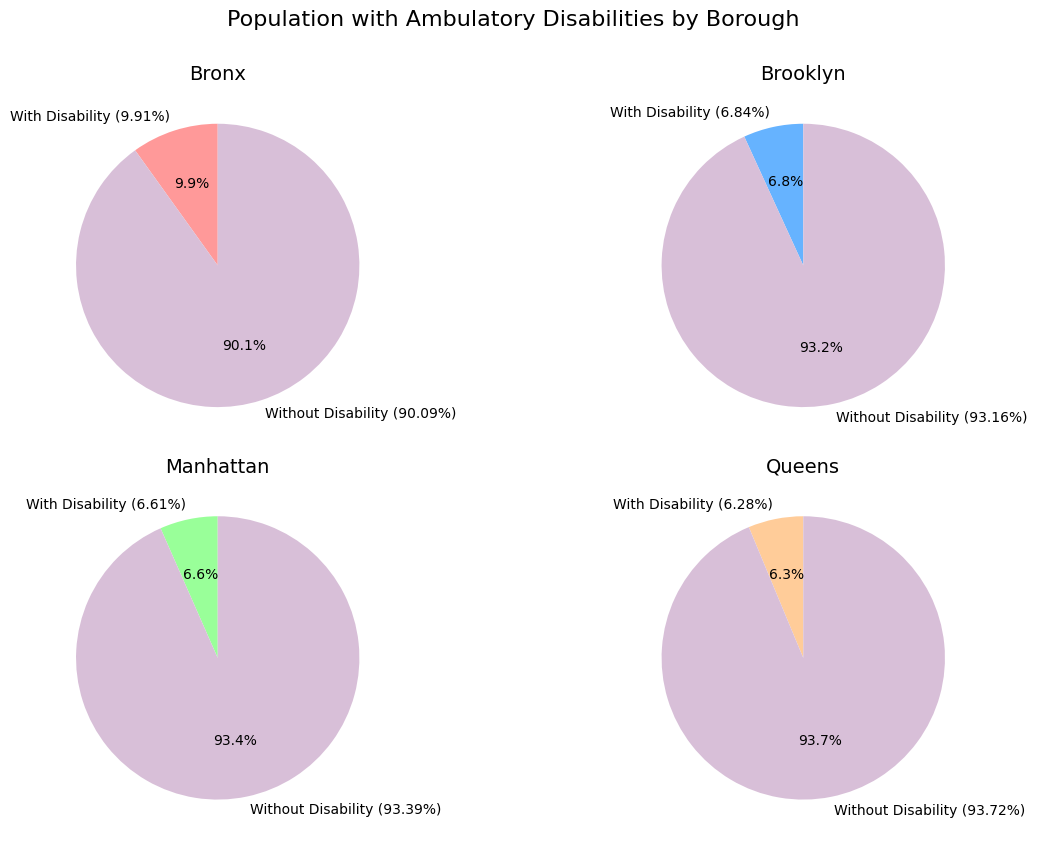

In [ ]:
# Prepare data for each borough
boroughs = borough_data['Borough']
percentages = borough_data['Percent with Ambulatory Disability']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 layout for 4 boroughs
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Define custom colors for each borough
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']  # Unique colors for each borough
background_color = '#D8BFD8'  # Purple for "Without Disability"

# Generate a pie chart for each borough
for i, borough in enumerate(boroughs):
    axes[i].pie(
        [percentages[i], 100 - percentages[i]],  # % with disability vs % without
        labels=[f"With Disability ({percentages[i]:.2f}%)", f"Without Disability ({100 - percentages[i]:.2f}%)"],
        autopct='%1.1f%%',
        startangle=90,
        colors=[colors[i], background_color]  # Borough color + purple
    )
    axes[i].set_title(borough, fontsize=14)

# Adjust layout and spacing
plt.tight_layout()
plt.suptitle('Population with Ambulatory Disabilities by Borough', fontsize=16, y=1.05)
plt.show()


WHAT: Here I take the final_filtered_dis_zip_dat_nyc and I find the total percentage of the NYC population that hasd an abulatory disability.

WHY: We want to quantify the issue of accessibility. Show the auidience that accessibility issues impact a large portion of the population and not just a handful.

In [ ]:
# Rename columns for easier manipulation
final_filtered_dis_zip_dat_nyc = final_filtered_dis_zip_dat_nyc.rename(columns={
    'Estimate of non-institutionalized civilian population': 'Population',
    'Percent of population with an ambulatory disability': 'Percent'
})

# Convert the Percent column to numeric, coercing errors
final_filtered_dis_zip_dat_nyc['Percent'] = pd.to_numeric(final_filtered_dis_zip_dat_nyc['Percent'], errors='coerce')

# Convert the Population column to numeric, coercing errors
final_filtered_dis_zip_dat_nyc['Population'] = pd.to_numeric(final_filtered_dis_zip_dat_nyc['Population'], errors='coerce')

# Drop rows with NaN values in Percent or Population
final_filtered_dis_zip_dat_nyc = final_filtered_dis_zip_dat_nyc.dropna(subset=['Percent', 'Population'])

# Convert Percent to a decimal for weighted calculation
final_filtered_dis_zip_dat_nyc['Percent'] = final_filtered_dis_zip_dat_nyc['Percent'] / 100

# Calculate the weighted percent
weighted_sum = (final_filtered_dis_zip_dat_nyc['Population'] * final_filtered_dis_zip_dat_nyc['Percent']).sum()
total_population = final_filtered_dis_zip_dat_nyc['Population'].sum()
overall_percent = (weighted_sum / total_population) * 100

print(f"Percent of NYC population with ambulatory disability: {overall_percent:.2f}%")

Percent of NYC population with ambulatory disability: 7.18%


WHAT: Here we visualize the above in a pie chart

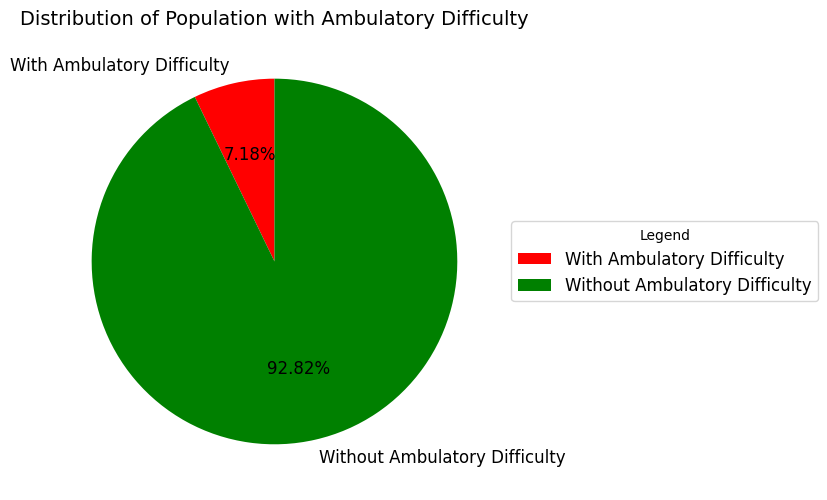

In [ ]:
# Data for the pie chart
percent_with_difficulty = 7.18
percent_without_difficulty = 100 - percent_with_difficulty

# Labels and sizes
labels = ['With Ambulatory Difficulty', 'Without Ambulatory Difficulty']
sizes = [percent_with_difficulty, percent_without_difficulty]

# Colors: Red for "with difficulty", Green for "without difficulty"
colors = ['red', 'green']

# Create the pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.2f%%',
    startangle=90,
    textprops={'fontsize': 12}
)

# Add a legend
plt.legend(
    wedges,
    labels,
    title="Legend",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

# Add a title
plt.title('Distribution of Population with Ambulatory Difficulty', fontsize=14)

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
Accessibility_Data_Bourough_PlatCount = accessibility[['borough','platform_count']]
Accessibility_Data_Bourough_PlatCount

borough  platform_count
240       Bronx              32
241    Brooklyn              90
242   Manhattan             153
243      Queens              50
244  Systemwide               4
..          ...             ...
400       Bronx              34
401    Brooklyn              98
402   Manhattan             167
403      Queens              59
404  Systemwide               4

[165 rows x 2 columns]

WHAT: Seeing how many accessible platforms each borough has

WHY: Important to know how much accessibility each borough has and this gives an introductory idea.

In [ ]:
# Filter data to include only the 4 main boroughs
main_boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens']
filtered_data = Accessibility_Data_Bourough_PlatCount[Accessibility_Data_Bourough_PlatCount['borough'].isin(main_boroughs)]

# Calculate mean platform count for each borough
mean_platform_count = filtered_data.groupby('borough')['platform_count'].mean().reset_index()

# Rename columns for clarity
mean_platform_count.columns = ['Borough', 'Mean Platform Count']

# Display the means
display(mean_platform_count)


Borough  Mean Platform Count
0      Bronx            32.363636
1   Brooklyn            93.636364
2  Manhattan           162.969697
3     Queens            54.515152

WHAT: Here we do thew same thing but for minutes available

In [ ]:
minutes_available.head()

month     borough  minutes_platforms_in_service
240  2022-01-01       Bronx                       1292847
241  2022-01-01    Brooklyn                       3696119
242  2022-01-01   Manhattan                       6377392
243  2022-01-01      Queens                       2115201
244  2022-01-01  Systemwide                      13481559

In [ ]:
# Filter data to include only the 4 main boroughs
main_boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens']
filtered_data = minutes_available[minutes_available['borough'].isin(main_boroughs)]

# Calculate mean minutes for each borough and reset the index to get a DataFrame
mean_minutes_df = filtered_data.groupby('borough', as_index=False)['minutes_platforms_in_service'].mean()

# Rename the column for clarity
mean_minutes_df = mean_minutes_df.rename(columns={'minutes_platforms_in_service': 'mean_minutes_in_service'})

# Display the resulting DataFrame
display(mean_minutes_df)


borough  mean_minutes_in_service
0      Bronx             1.354569e+06
1   Brooklyn             3.964251e+06
2  Manhattan             6.821234e+06
3     Queens             2.280870e+06

WHAT: Here we plot a histogram of the availability of the accessible platforms in each borough

WHY: This allows us to visualize if there are any major/minor discrepencies in how often the accessible stations are actaually available between each borough

In [ ]:
accessibility_borough = accessibility[['borough','availability']]

def plot_histograms(filtered_cleaned_data, column, category_column, categories, bins=25):
    """
    Plots histograms for a specified column grouped by categories, with each histogram in a separate plot,
    optionally saving the plots to a specified directory. Removes outliers before plotting.

    Parameters:
        filtered_cleaned_data (DataFrame): The dataset containing the data to plot.
        column (str): The column to plot histograms for.
        category_column (str): The column containing the categories (e.g., boroughs).
        categories (list): The list of categories to plot (e.g., ['Bronx', 'Manhattan', 'Brooklyn', 'Queens']).
        bins (int): Number of bins for the histograms.
    """
    def remove_outliers_iqr(series):
        """
        Removes outliers from a series using the Interquartile Range (IQR) method.

        Parameters:
            series (pd.Series): The data series to remove outliers from.

        Returns:
            pd.Series: The data series with outliers removed.
        """
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        return series[(series >= (Q1 - 1.5 * IQR)) & (series <= (Q3 + 1.5 * IQR))]

    # Remove outliers for the specified column grouped by category_column
    filtered_cleaned_data[column] = (
        filtered_cleaned_data.groupby(category_column)[column]
        .transform(remove_outliers_iqr)
    )

    # Drop rows with NaN values after outlier removal
    filtered_cleaned_data = filtered_cleaned_data.dropna(subset=[column])

    # Determine global range for consistent x-ticks
    global_min = filtered_cleaned_data[column].min()
    global_max = filtered_cleaned_data[column].max()
    bin_edges = [global_min + (global_max - global_min) * i / bins for i in range(bins + 1)]

    for category in categories:
        subset = filtered_cleaned_data[filtered_cleaned_data[category_column] == category][column]

        # Compute mean and median
        mean = subset.mean()
        median = subset.median()

        # Create plot
        plt.figure(figsize=(10, 6))
        counts, _, _ = plt.hist(subset, bins=bin_edges, alpha=0.7, color='skyblue', edgecolor='black', label='Histogram')
        plt.axvline(mean, color='blue', linestyle='--', linewidth=2, label=f'Mean')
        plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median')
        plt.title(f"{category} - {column.capitalize()} (Outliers Removed)")
        plt.ylabel('Frequency')
        plt.xlabel(column.capitalize())

        # Set consistent x-tick marks across all plots
        plt.xticks(bin_edges, [f"{tick:.3f}" for tick in bin_edges], rotation=45)

        # Add legend
        plt.legend(loc='upper right')

        # Adjust layout
        plt.tight_layout()

        # Show the plot
        plt.show()

<ipython-input-120-da6fced8209e>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



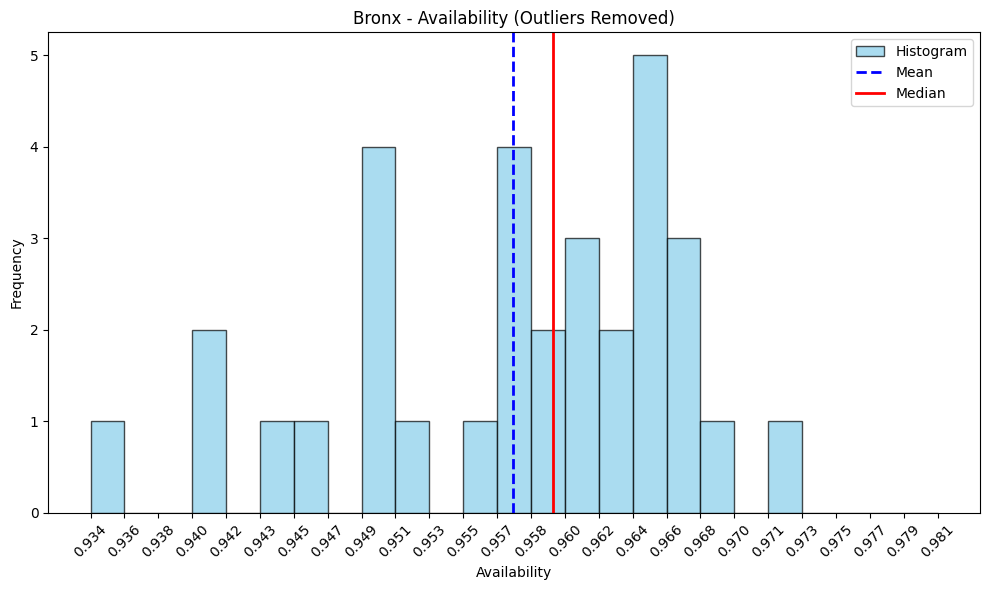

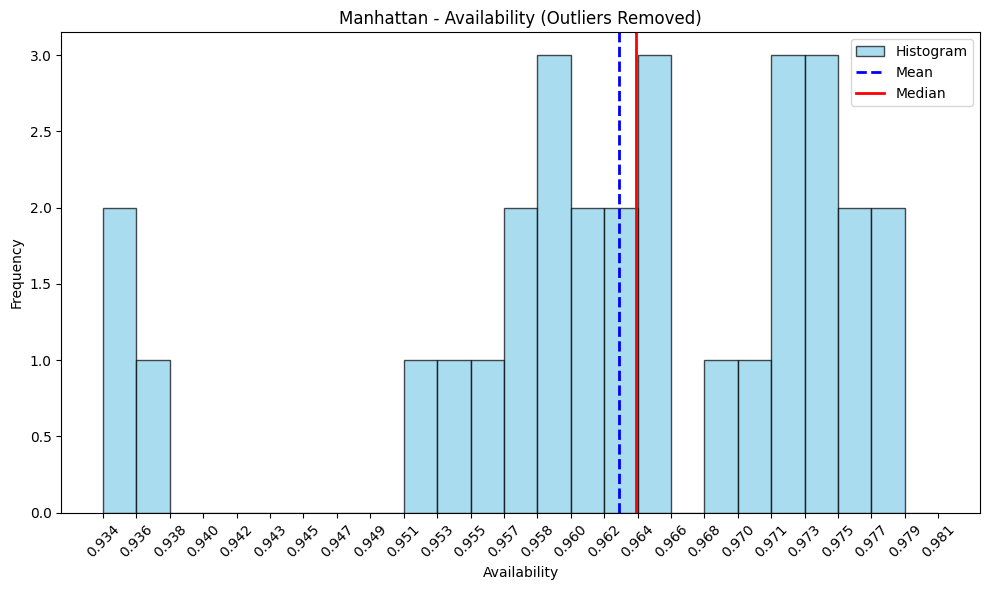

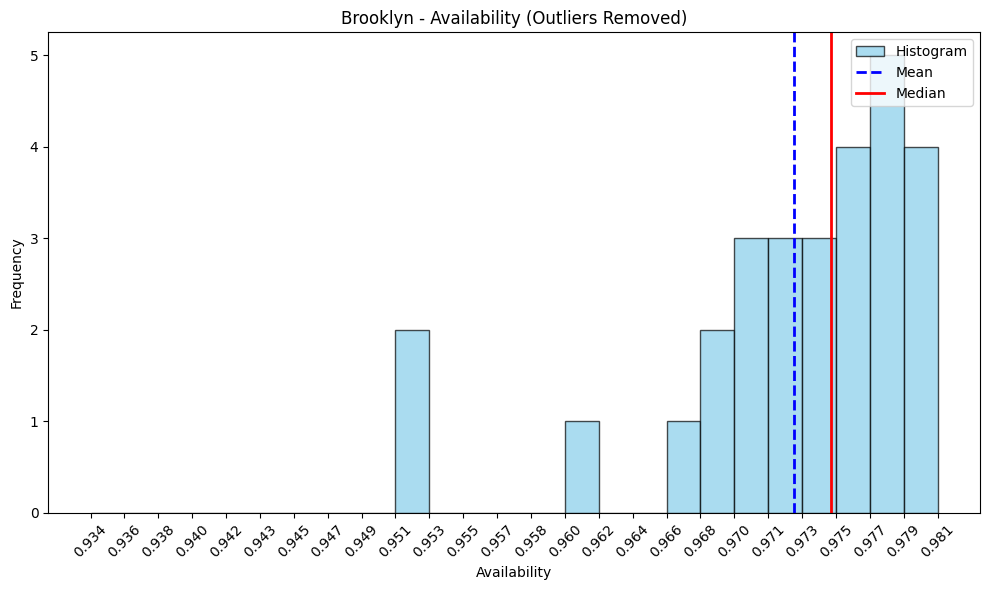

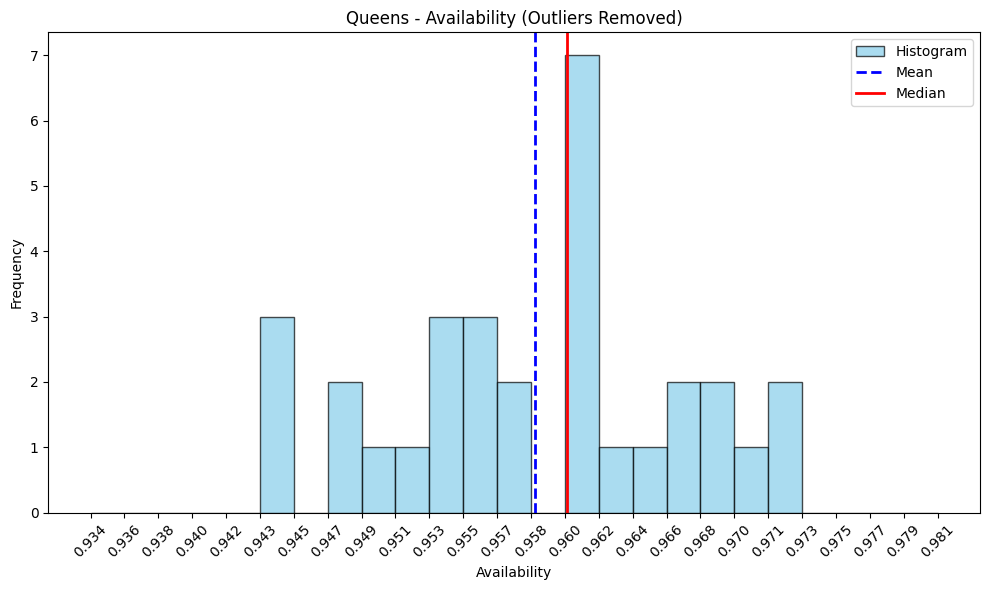

In [ ]:
# Function Calling
plot_histograms(
    filtered_cleaned_data=accessibility_borough,
    column='availability',
    category_column='borough',
    categories=['Bronx', 'Manhattan', 'Brooklyn', 'Queens'],
    bins=25,
)

WHAT: Visualizing the trend in availability of the accessible stations over time.

WHY: This helps see if accessibility has gotten worse, bettter, or stayed roughly the same over the past two years. NOT USED See Appendix

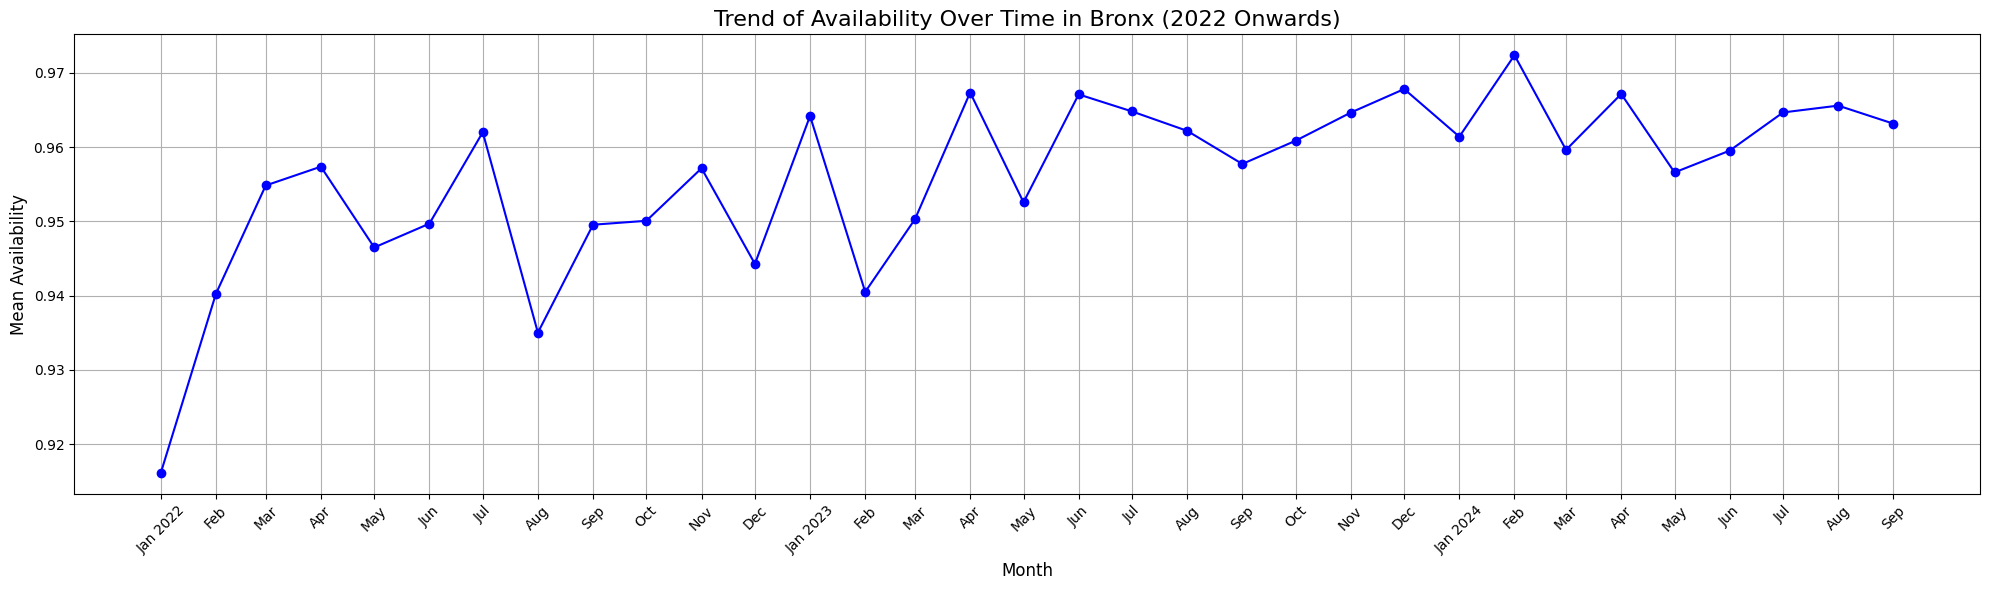

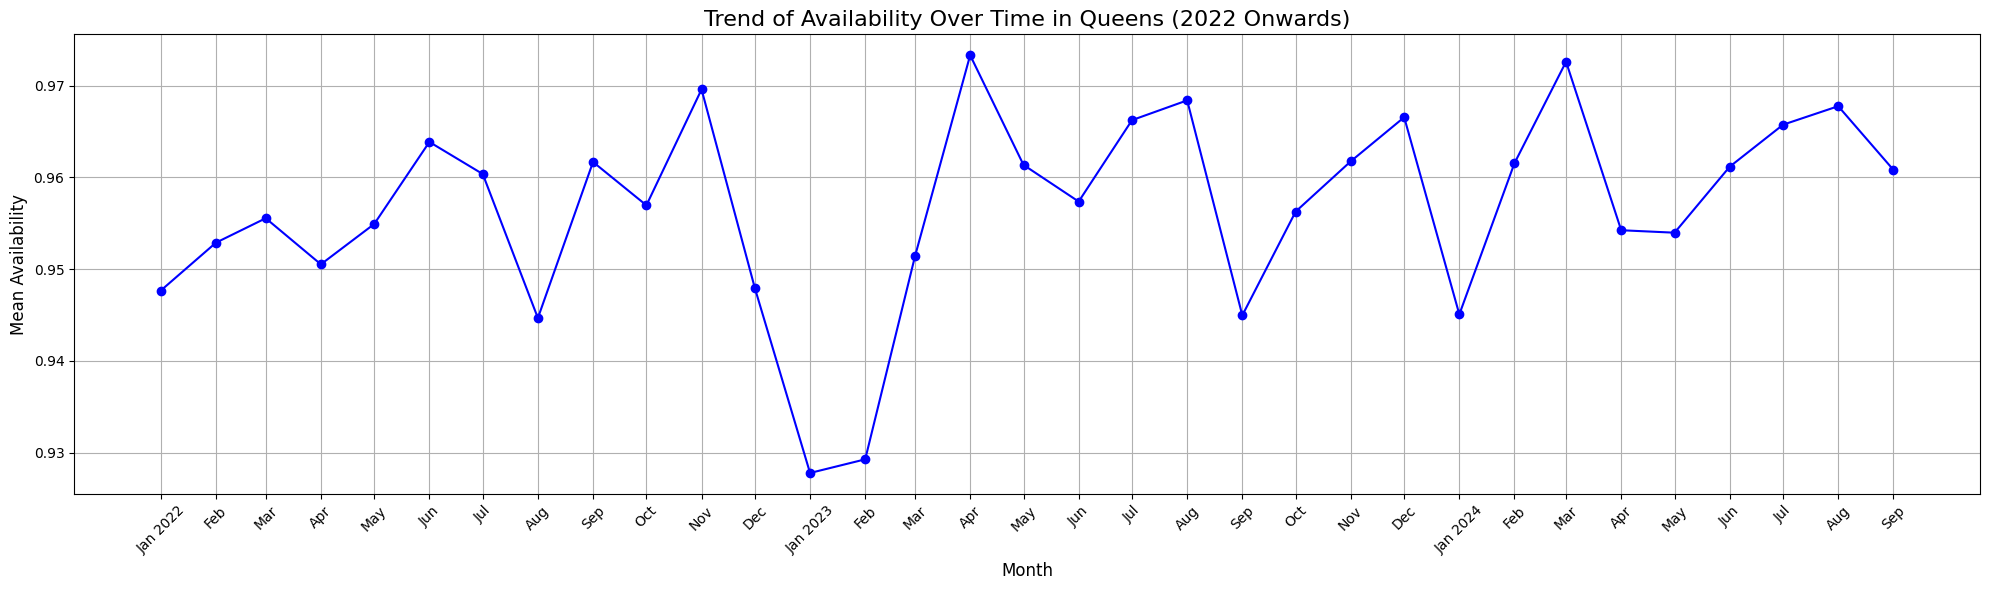

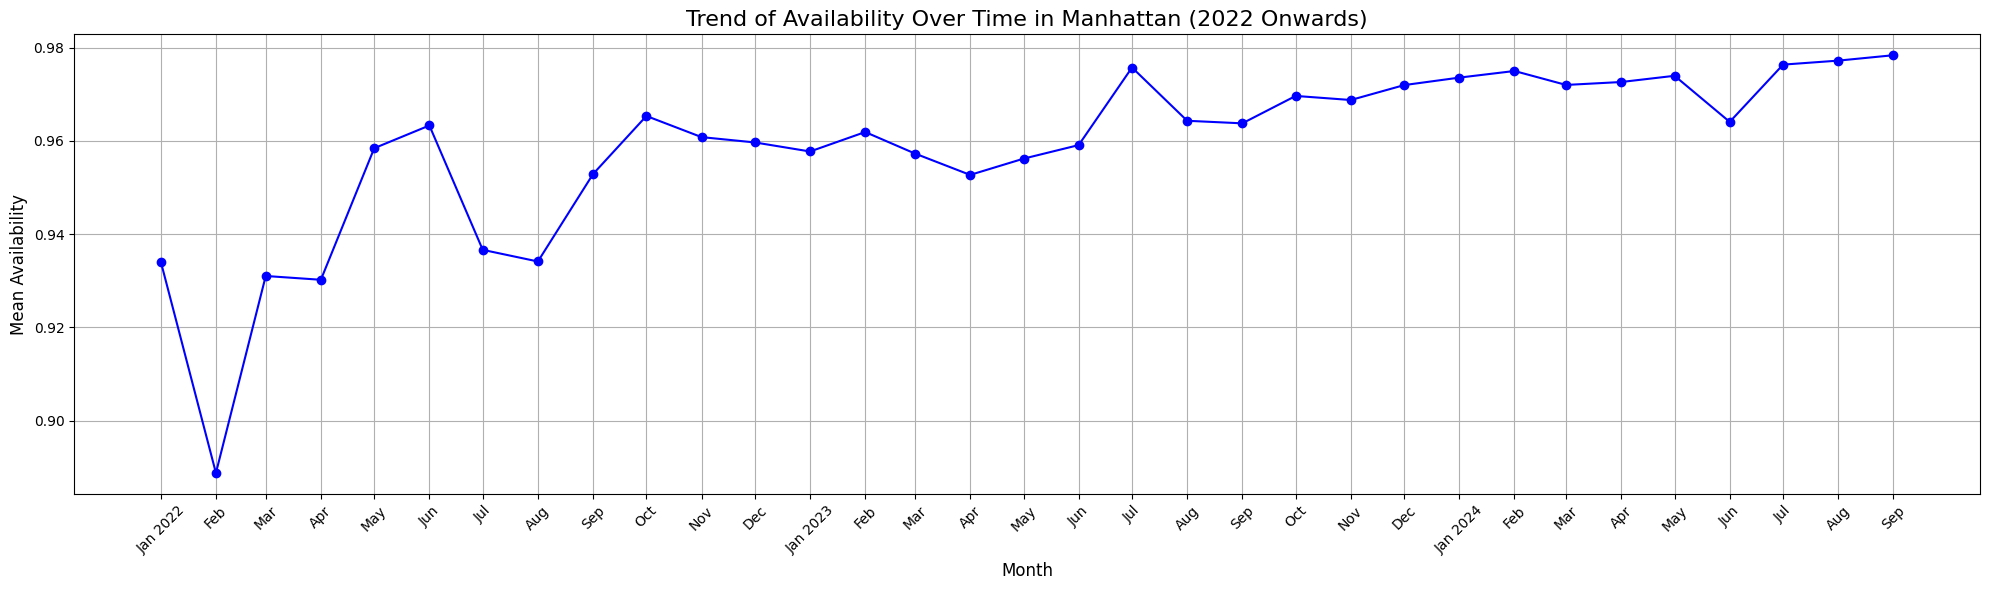

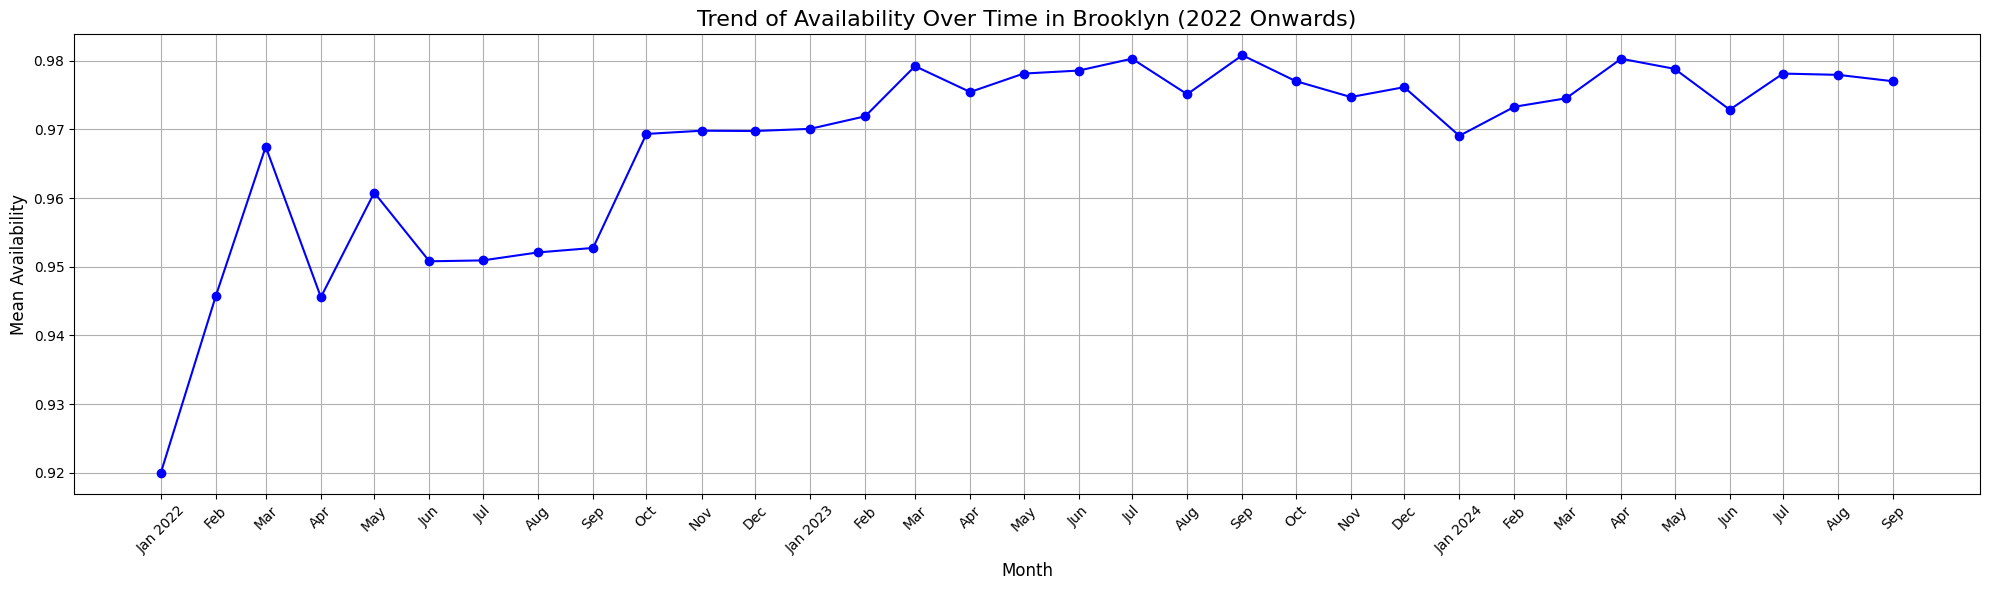

In [ ]:
# Ensure 'month' is in datetime format
accessibility['month'] = pd.to_datetime(accessibility['month'])

# Filter data to include only months from 2022 onwards
accessibility_filtered = accessibility[accessibility['month'] >= '2022-01-01']

# List of boroughs to analyze
boroughs = ['Bronx', 'Queens', 'Manhattan', 'Brooklyn']

# Loop through each borough and create plots
for borough in boroughs:
    # Filter data for the borough
    borough_data = accessibility_filtered[accessibility_filtered['borough'] == borough]

    # Group by 'month' and calculate mean availability
    monthly_trends = borough_data.groupby('month')['availability'].mean()

    # Plot Availability Trend for the borough
    plt.figure(figsize=(20, 6))
    plt.plot(monthly_trends.index, monthly_trends, label='Availability', marker='o', color='blue')
    plt.title(f'Trend of Availability Over Time in {borough} (2022 Onwards)', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Mean Availability', fontsize=12)
    plt.xticks(
        monthly_trends.index,
        [date.strftime('%b %Y') if date.month == 1 else date.strftime('%b') for date in monthly_trends.index],
        rotation=45,
        fontsize=10
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()

WHAT: Here we again visualize the trend in availability of accessible stations in the past two years, except that we normalize by the number of days in each month, taking in to account that 2024 is a leap year and has 29 days.

WHY: So we can see if there are any marked differences over the past two years

In [ ]:
# Define the number of days in each month for 2022, 2023, and 2024
days_in_month = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
}

# Adjust February for leap year 2024
leap_year_days_in_month = days_in_month.copy()
leap_year_days_in_month[2] = 29

In [ ]:
# Add a column for the total minutes in each month
def calculate_total_minutes(row):
    year = row['month'].year
    month = row['month'].month
    if year == 2024:  # Leap year
        return leap_year_days_in_month[month] * 24 * 60
    else:  # Non-leap year
        return days_in_month[month] * 24 * 60

accessibility_filtered['total_minutes'] = accessibility_filtered.apply(calculate_total_minutes, axis=1)

# Normalize availability by total minutes in the month
accessibility_filtered['normalized_availability'] = (
    accessibility_filtered['availability'] / accessibility_filtered['total_minutes']
)


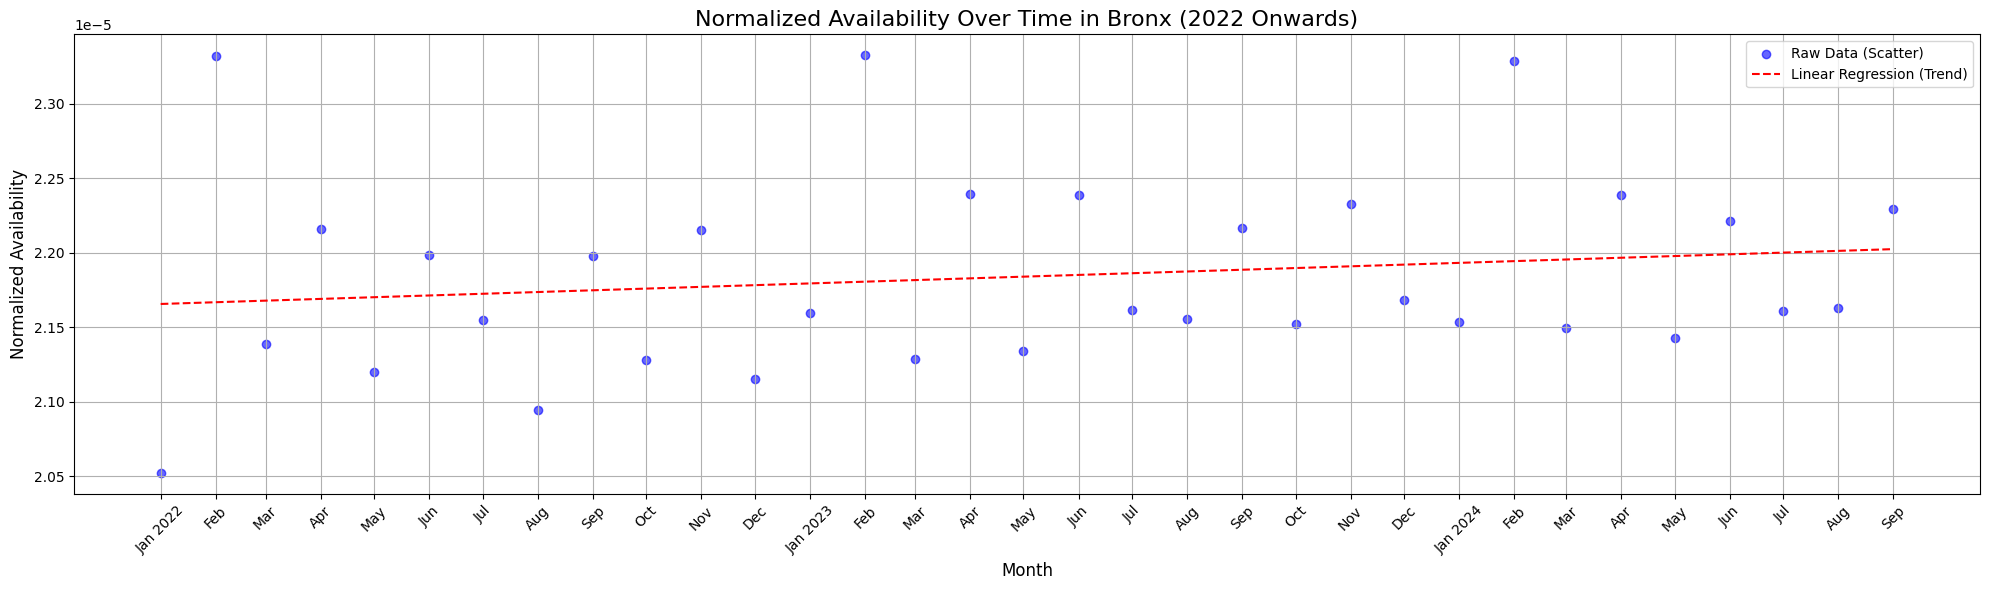

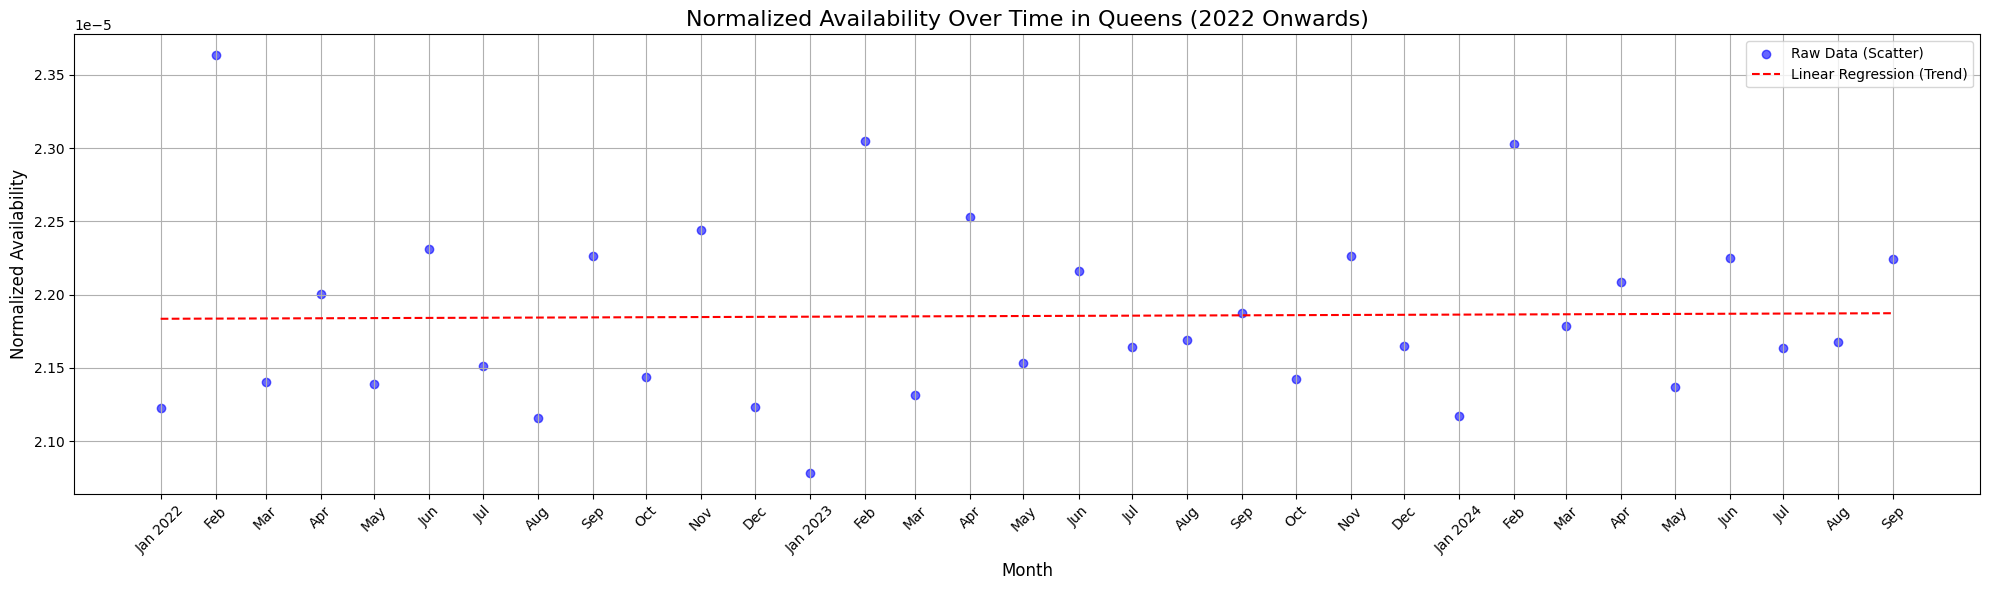

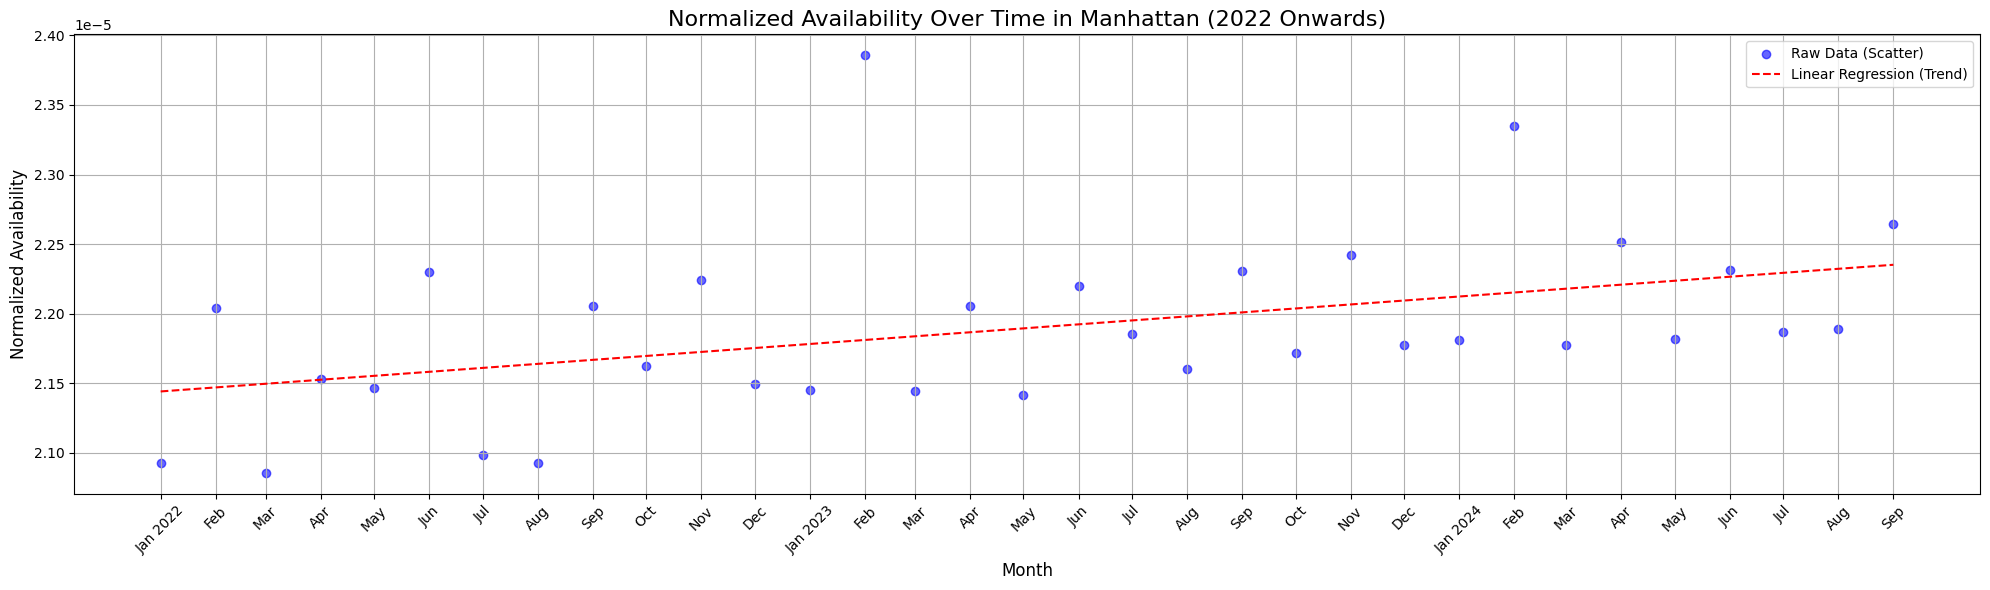

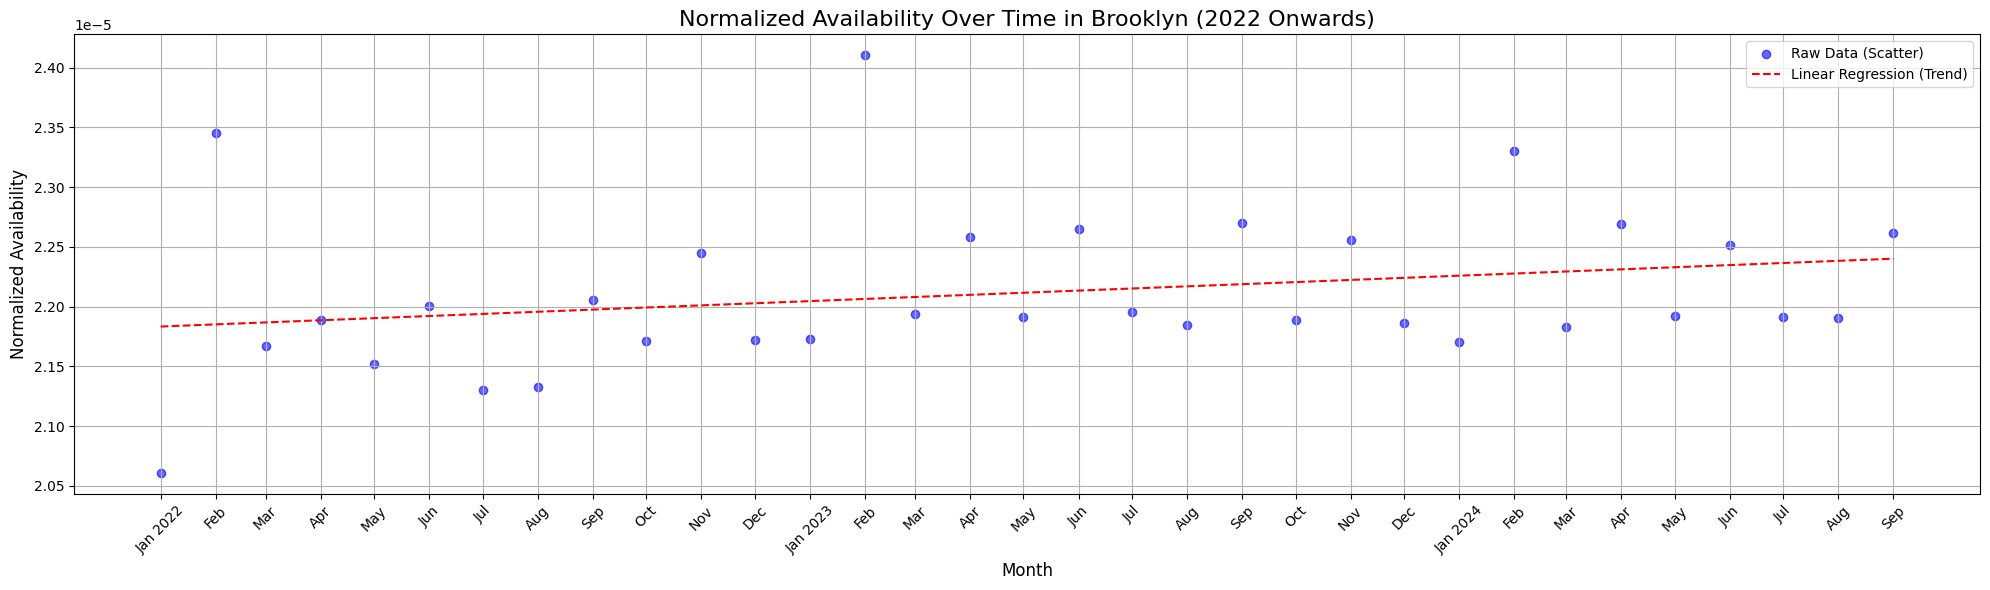

Slopes and R-squared Values of the Linear Regression Lines:
Bronx:
    Slope: 0.000000 units/day, which is about 0.000000% change per day.
    This corresponds to about 0.00% change per year.
    Coefficient of Determination (R^2): 0.0289

Queens:
    Slope: 0.000000 units/day, which is about 0.000000% change per day.
    This corresponds to about 0.00% change per year.
    Coefficient of Determination (R^2): 0.0003

Manhattan:
    Slope: 0.000000 units/day, which is about 0.000000% change per day.
    This corresponds to about 0.00% change per year.
    Coefficient of Determination (R^2): 0.1846

Brooklyn:
    Slope: 0.000000 units/day, which is about 0.000000% change per day.
    This corresponds to about 0.00% change per year.
    Coefficient of Determination (R^2): 0.0656



In [ ]:

# Initialize dictionaries for slopes and R-squared values
slopes = {}
r_squared_values = {}

for borough in boroughs:
    # Filter data for the borough
    borough_data = accessibility_filtered[accessibility_filtered['borough'] == borough]

    # Scatter plot for raw data
    plt.figure(figsize=(20, 6))
    plt.scatter(borough_data['month'], borough_data['normalized_availability'], label='Raw Data (Scatter)', color='blue', alpha=0.6)

    # Linear regression for trend
    x = borough_data['month'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)  # Convert datetime to ordinal for regression
    y = borough_data['normalized_availability'].values
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    # Store the slope of the line (regression coefficient)
    slope = model.coef_[0]
    slopes[borough] = slope

    # Compute the coefficient of determination (R^2)
    r_squared = model.score(x, y)
    r_squared_values[borough] = r_squared

    # Plot the regression line
    plt.plot(borough_data['month'], y_pred, label=f'Linear Regression (Trend)', color='red', linestyle='--')

    # Customizing the plot
    plt.title(f'Normalized Availability Over Time in {borough} (2022 Onwards)', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Normalized Availability', fontsize=12)
    plt.xticks(
        pd.date_range(start=borough_data['month'].min(), end=borough_data['month'].max(), freq='MS'),
        [date.strftime('%b %Y') if date.month == 1 else date.strftime('%b') for date in pd.date_range(start=borough_data['month'].min(), end=borough_data['month'].max(), freq='MS')],
        rotation=45,
        fontsize=10
    )
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print the slopes and R-squared values for each borough with explanations
print("Slopes and R-squared Values of the Linear Regression Lines:")
for borough in boroughs:
    slope = slopes[borough]
    r_squared = r_squared_values[borough]
    daily_percent_change = slope * 100  # Convert to percentage change per day
    yearly_percent_change = daily_percent_change * 365  # Convert to percentage change per year
    print(f"{borough}:")
    print(f"    Slope: {slope:.6f} units/day, which is about {daily_percent_change:.6f}% change per day.")
    print(f"    This corresponds to about {yearly_percent_change:.2f}% change per year.")
    print(f"    Coefficient of Determination (R^2): {r_squared:.4f}")
    print()


WHAT:Was originally filtering by subject detail that we most applicable to disbility accessibility

WHY:Understand proportion of those most related versus those not... Not Used

In [ ]:
# Filter the dataset based on all provided conditions
filtered_data = MTA_Feedback_Data[
    (MTA_Feedback_Data['Agency'] == 'Subways') &  # Keep rows where 'Agency' is 'Subways'
    (MTA_Feedback_Data['Commendation or Complaint'] != 'Commendation') &  # Exclude rows where 'Commendation or Complaint' is 'Commendation'
    (MTA_Feedback_Data['Subject Matter'].isin(['Service', 'Other', 'Rules & Regulations', 'Trains',
                                               'Travel Disruption / Trip Problem',
                                               'Station /Bus Stop /Facility /Structure', 'Complaint',
                                               'Reasonable Modification', 'Station', 'Train', 'Facility',
                                               'Construction / Capital Projects', 'Public Hearing']))  # Keep rows where 'Subject Matter' matches allowed values
]

# Remove rows where 'Subject Detail' is NaN or 'No Value'
filtered_data = filtered_data.dropna(subset=['Subject Detail'])
filtered_data = filtered_data[filtered_data['Subject Detail'] != 'No Value']

# Save the filtered dataset to a new CSV
filtered_data.to_csv("Filtered_MTA_Feedback.csv", index=False)

# Display the first few rows of the filtered dataset
filtered_data.head()

Agency Commendation or Complaint  \
20479  Subways                 Complaint   
20480  Subways                 Complaint   
20485  Subways                 Complaint   
20486  Subways                 Complaint   
20494  Subways                 Complaint   

                               Subject Matter        Subject Detail  \
20479  Station /Bus Stop /Facility /Structure     Station - General   
20480                                 Station              Elevator   
20485                                   Train                 Other   
20486                                 Station  Track / Right-of-Way   
20494                                   Train                 Other   

                              Issue Detail  Year  Quarter Branch/Line/Route  
20479                     Homeless Present  2019        4                 J  
20480  Operating Conditions / Availability  2019        4                 D  
20485             Appearance / Cleanliness  2019        4                 A  
20486             Appearance / Cleanliness  2019        4                 7  
20494             Appearance / Cleanliness  2019        4                 4

WHAT: Looking at the proportion of unique subject detail complaints

WHY: To better understand the most common subject detail complaint

In [ ]:
# Calculate the proportion of each unique value in the 'Subject Detail' column
value_counts = MTA_Feedback_Data['Subject Detail'].value_counts(normalize=True) * 100

# Convert to a DataFrame for better visualization
proportions_df = value_counts.reset_index()
proportions_df.columns = ['Subject Detail', 'Proportion (%)']

# Save the proportions to a CSV for review
proportions_df.to_csv("Proportions_Subject_Detail.csv", index=False)

# Display the proportions DataFrame
proportions_df[0:20]

Subject Detail  Proportion (%)
0             Rail / Subway Cars       16.066708
1                Train - General       14.227483
2              Station - General        9.778096
3                       No Value        8.943542
4                Ticket Machines        6.991221
5   Ticket Clerk / Station Agent        6.970958
6                      Platforms        3.496082
7                Train Conductor        2.779335
8                        Website        2.170502
9           Track / Right-of-Way        2.055521
10                    Turnstiles        1.990019
11                       Signage        1.789274
12                     Schedules        1.776079
13                     Staircase        1.776079
14                       Tickets        1.646961
15                     Escalator        1.450457
16                         Other        1.311443
17            Fare / Toll Policy        1.104100
18                         Clock        1.051322
19     Train Operator / Engineer        0.889689

In [ ]:
# MTA_Feedback_Data['Issue Detail'].unique()

WHAT: Out of above list, I choose those most impactful to accessibility

WHY: Understand the proportion of mpost impactful complaints versus not

In [ ]:
target_issue_details = ['Operating Conditions / Availability',
       'Needs Repair / Damaged / Not Working',
       'Improper Function/Needs Repair/Damaged',
       'Not Working / Out of Service',
       'Accessibility Due To Construction', 'Leaking / Wet', 'Duration of Construction', 'Stuck',
       'Difficulty Boarding / Entering','Bumpy Ride / Vibrations', 'Hard To Read',
       'Equipment Breakdown','Crowding',
       'Dark',
       'Hard to Read',
       'Difficulty Leaving / Exiting',
       'Obstruction','Gap Issue',
    'No elevator announcement',
       'AutoGate not accessible', 'Blocked','Snow / Ice']

WHAT: Plotting the target list propoirtion versus all else

WHY: To see the proportion described above

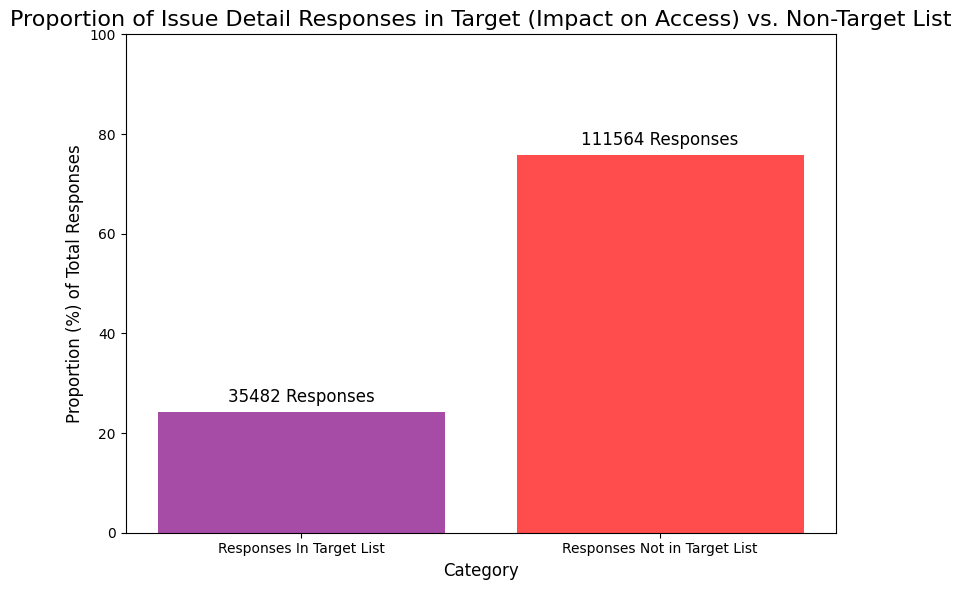

In [ ]:
# Calculate the total number of rows
total_rows = len(filtered_data)

# Calculate the proportion of rows in and not in the target list
in_target_count = filtered_data['Issue Detail'].isin(target_issue_details).sum()
not_in_target_count = total_rows - in_target_count

in_target_proportion = (in_target_count / total_rows) * 100
not_in_target_proportion = (not_in_target_count / total_rows) * 100

# Create data for the bar plot
categories = ["Responses In Target List", "Responses Not in Target List"]
proportions = [in_target_proportion, not_in_target_proportion]
counts = [in_target_count, not_in_target_count]

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, proportions, color=['purple', 'red'], alpha=0.7)

# Add the actual counts on top of each bar
for bar, count in zip(bars, counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
        bar.get_height() + 2,  # Y position (slightly above the bar)
        f'{count} Responses',  # Text to display
        ha='center', fontsize=12, color='black'
    )

# Add labels and title
plt.title("Proportion of Issue Detail Responses in Target (Impact on Access) vs. Non-Target List", fontsize=16)
plt.ylabel("Proportion (%) of Total Responses", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.ylim(0, 100)  # Limit y-axis to 100%

# Display the bar plot
plt.tight_layout()
plt.show()


In [ ]:
# Filter the dataset to keep only rows where 'Subject Detail' is 'Rail / Subway Cars'
rail_subway_cars_data = MTA_Feedback_Data[
    (MTA_Feedback_Data['Agency'] == 'Subways') &
    (MTA_Feedback_Data['Commendation or Complaint'] != 'Commendation') &
    (MTA_Feedback_Data['Subject Matter'].isin(['Service', 'Other', 'Rules & Regulations', 'Trains',
                                               'Travel Disruption / Trip Problem',
                                               'Station /Bus Stop /Facility /Structure', 'Complaint',
                                               'Reasonable Modification', 'Station', 'Train', 'Facility',
                                               'Construction / Capital Projects', 'Public Hearing'])) &
    (MTA_Feedback_Data['Subject Detail'] == 'Rail / Subway Cars')  # Keep only rows with 'Rail / Subway Cars'
]

# Save the resulting dataset to a new CSV
rail_subway_cars_data.to_csv("Rail_Subway_Cars_MTA_Feedback.csv", index=False)

# Display the first few rows of the filtered dataset
rail_subway_cars_data.head()

Agency Commendation or Complaint Subject Matter      Subject Detail  \
20553  Subways                 Complaint         Trains  Rail / Subway Cars   
21156  Subways                 Complaint         Trains  Rail / Subway Cars   
21484  Subways                 Complaint         Trains  Rail / Subway Cars   
21556  Subways                 Complaint         Trains  Rail / Subway Cars   
21743  Subways                 Complaint         Trains  Rail / Subway Cars   

           Issue Detail  Year  Quarter Branch/Line/Route  
20553  Homeless Present  2019        4                 1  
21156          Too Cold  2019        4                 6  
21484           Too Hot  2019        4                 Q  
21556           Too Hot  2019        4                 D  
21743  Homeless Present  2019        4                 4

WHAT: Limiting dataset to subject detail complaints that related most to accessibility

WHY: Want to see the most common issues for the subjects that mosty impact access

In [ ]:
# Define the list of values for the 'Subject Detail' column
target_values = ['Elevator', 'Platform', 'Seats / Benches', 'Staircase',
                 'Operating Conditions / Availability', 'Door',
                 'Emergency Gate / Door', 'Escalator', 'Sidewalk', 'Lighting',
                 'Accessibility Feature', 'Doors (Train, Bus, Facility)',
                 'Platforms', 'Station Gates', 'Pedestrian Overpass / Underpass',
                 'Passenger Walkways', 'Emergency Gate/Door', 'Fence', 'Elevators',
                 'Auto Gate', 'HelpPoint / Customer Service Intercom',
                 'Pedestrian Walkways']

In [ ]:
# Get the unique 'Issue Detail' values for rows where 'Subject Detail' is in the target list
unique_issue_details_target = filtered_data[filtered_data['Subject Detail'].isin(target_values)]['Issue Detail'].dropna().unique()

# Convert the unique 'Issue Detail' values to a list
unique_issue_details_list = unique_issue_details_target.tolist()

# Print the list
print(unique_issue_details_list)


['Operating Conditions / Availability', 'Appearance / Cleanliness', 'Needs Repair / Damaged / Not Working', 'Improper Function/Needs Repair/Damaged', 'Security / Police Matters', 'Website Status Incorrect', 'Other', 'Not Working / Out of Service', 'Accessibility Due To Construction', 'Litter / Garbage / Debris', 'Cleanliness', 'Unauthorized / Criminal Activity', 'Smoke / Fumes / Smell / Odor', 'Leaking / Wet', 'Duration of Construction', 'Stuck', 'Caught In Closing Door', 'Difficulty Boarding / Entering', 'Homeless Present', 'Drainage', 'Graffiti', 'Accuracy / Correctness - Visual / Text', 'Dark', 'Rats / Mice', 'Add More / Not Enough', 'Poor Location', 'Crowding', 'Accuracy / Correctness - Visual/Text', 'Too Hot', 'Clarity - Visual / Text', 'Closed', 'Difficulty Leaving / Exiting', 'Noise', 'Pigeons / Birds', 'Gap Issue', 'Closed / Not Open / Locked', 'No Announcement / Message - Visual/Text', 'No Announcement / Messages - Audio', 'No Announcement / Messages - Visual/Text', 'Announcem

WHAT: Visualizing the issue details proportions for the targeted subject detail

WHY: To see most common issues within most impactful subject detail

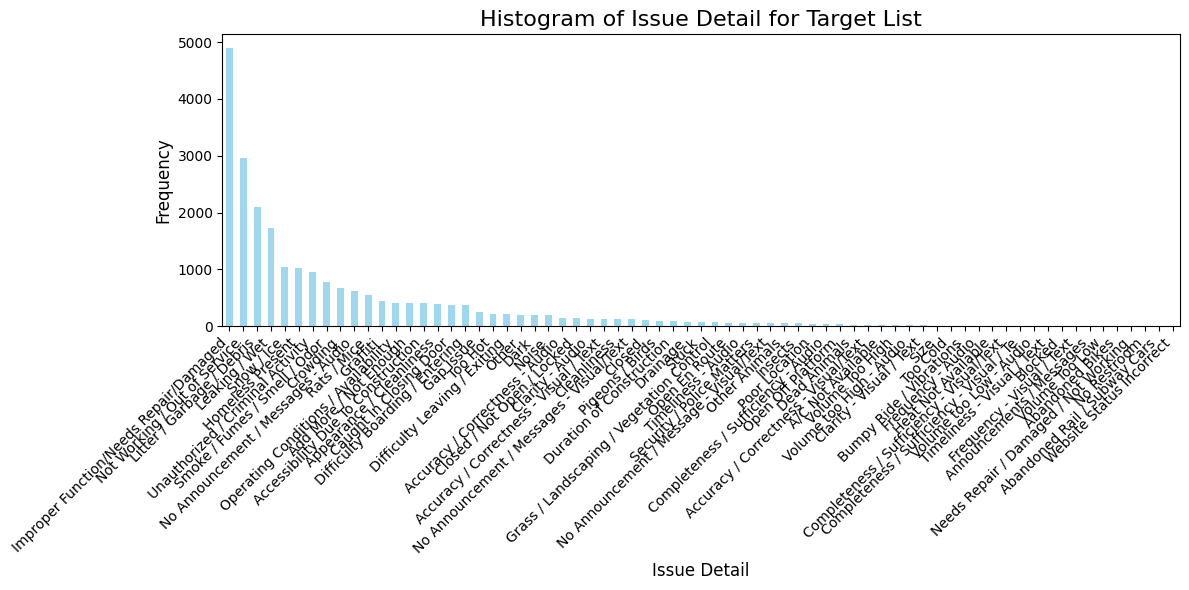

In [ ]:
# Get the counts of each unique 'Issue Detail' value for rows in the target list
issue_detail_counts = filtered_data[filtered_data['Subject Detail'].isin(target_values)]['Issue Detail'].value_counts()

# Plot a histogram of the 'Issue Detail' values
plt.figure(figsize=(12, 6))
issue_detail_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Customize the plot
plt.title('Histogram of Issue Detail for Target List', fontsize=16)
plt.xlabel('Issue Detail', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

WHAT: Issue Detail most impactful to accessibility, but this is only when subject detail is also in the target list

WHY: Want to see out of the above issues, which ones are most common ... this shows which issue that impacts accessibility is most common out of all complaints for accessuibility

In [ ]:
target_issue_details = ['Operating Conditions / Availability',
       'Needs Repair / Damaged / Not Working',
       'Improper Function/Needs Repair/Damaged',
       'Not Working / Out of Service',
       'Accessibility Due To Construction', 'Leaking / Wet', 'Duration of Construction', 'Stuck',
       'Difficulty Boarding / Entering','Bumpy Ride / Vibrations', 'Hard To Read',
       'Equipment Breakdown','Crowding',
       'Dark',
       'Hard to Read',
       'Difficulty Leaving / Exiting',
       'Obstruction','Gap Issue',
    'No elevator announcement',
       'AutoGate not accessible', 'Blocked','Snow / Ice']

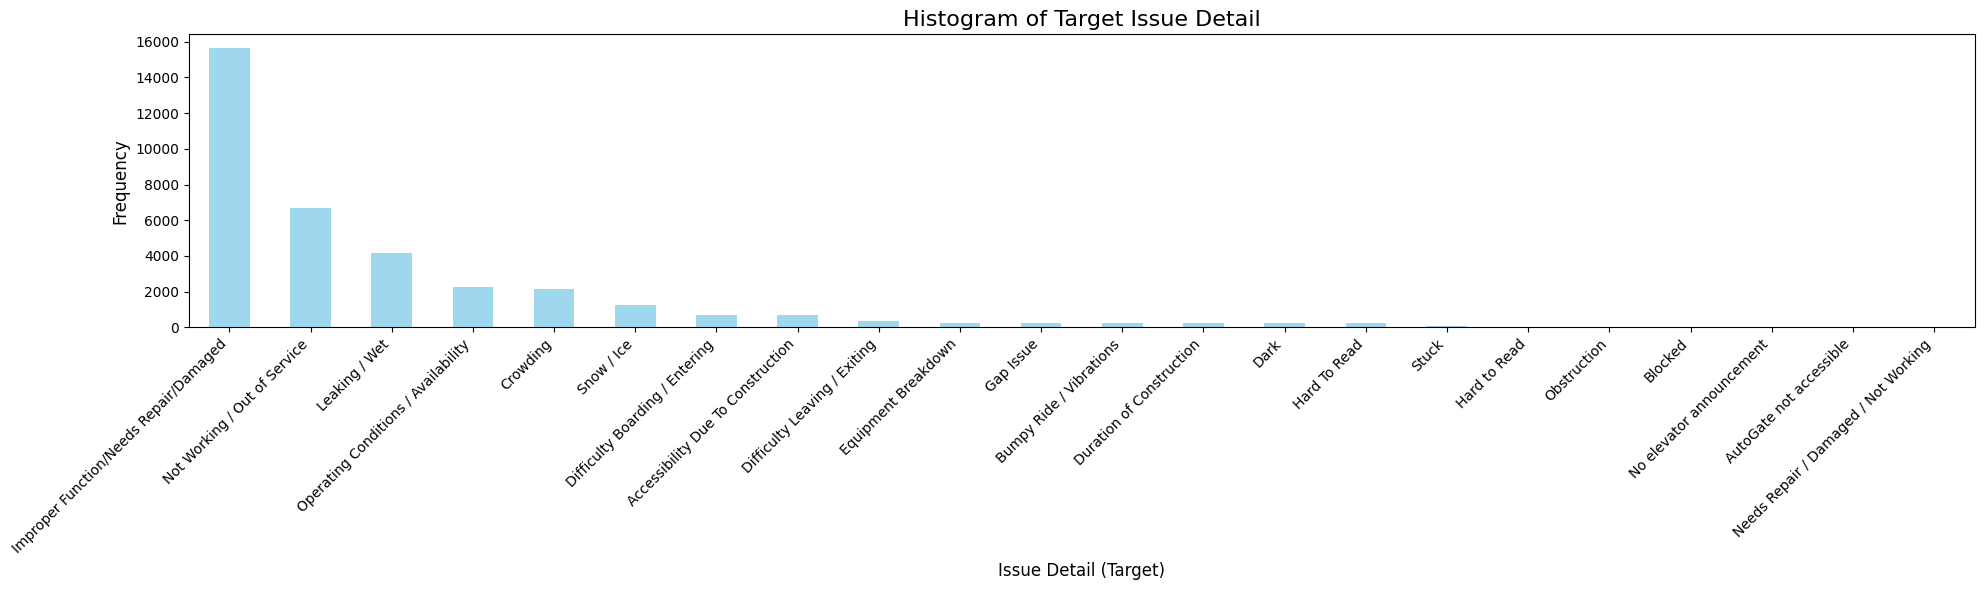

In [ ]:
# Filter the dataset to include only rows where 'Issue Detail' is in the target list
target_issue_details_data = filtered_data[filtered_data['Issue Detail'].isin(target_issue_details)]

# Get the counts of each unique 'Issue Detail' value in the target list
target_issue_detail_counts = target_issue_details_data['Issue Detail'].value_counts()

# Plot a histogram of the target 'Issue Detail' values
plt.figure(figsize=(20, 6))  # Increase the width of the x-axis
target_issue_detail_counts.plot(kind='bar', color='skyblue', alpha=0.8)

# Customize the plot
plt.title('Histogram of Target Issue Detail', fontsize=16)
plt.xlabel('Issue Detail (Target)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust font size for better readability
plt.tight_layout()

# Show the histogram
plt.show()


WHAT: The above is too convoluted, and I think it is better to just consider all issue details, but still control for subways and complaints.

WHY: More clear picture and less convoluted

In [ ]:
print(MTA_Feedback_Data['Issue Detail'].unique().tolist())


['Homeless Present', 'Operating Conditions / Availability', 'Customer Actions / Behavior', 'Customer Service / Behavior', 'Appearance / Cleanliness', 'Security / Police Matters', nan, 'Operating Performance', 'Announcements / Messages', 'Needs Repair / Damaged / Not Working', 'Unauthorized / Criminal Activity', 'Operating Safety', 'Improper Function/Needs Repair/Damaged', 'Too Cold', 'Website Status Incorrect', 'Too Hot', 'Late / Delay Current', 'Major Service Disruption', 'A/C Not Available', 'Other', 'Rude / Inappropriate Language', 'Not Working / Out of Service', 'Completeness / Sufficiency - Audio', 'Accessibility Due To Construction', 'Litter / Garbage / Debris', 'Error Message - Swipe Again', 'Fare Evasion', 'Track / Right-of-Way', 'MetroCard Balance Protection', 'Non-Work Related Distractions', 'Closed Door Before Customer Could Board', 'Not Helpful', 'Reckless Driving', 'Leaking / Wet', 'Track Change', 'Clarity - Audio', 'Cleanliness', 'Failure To Make Scheduled Stop', 'Accurac

WHAT: Creating a histogram of all the issue details. Highlighting in PURPLE the issue details most impactful to accessibility.

WHY: Allows to identify the most common complaint issue. The color coding allows us to determine most common issue affecting accessibility

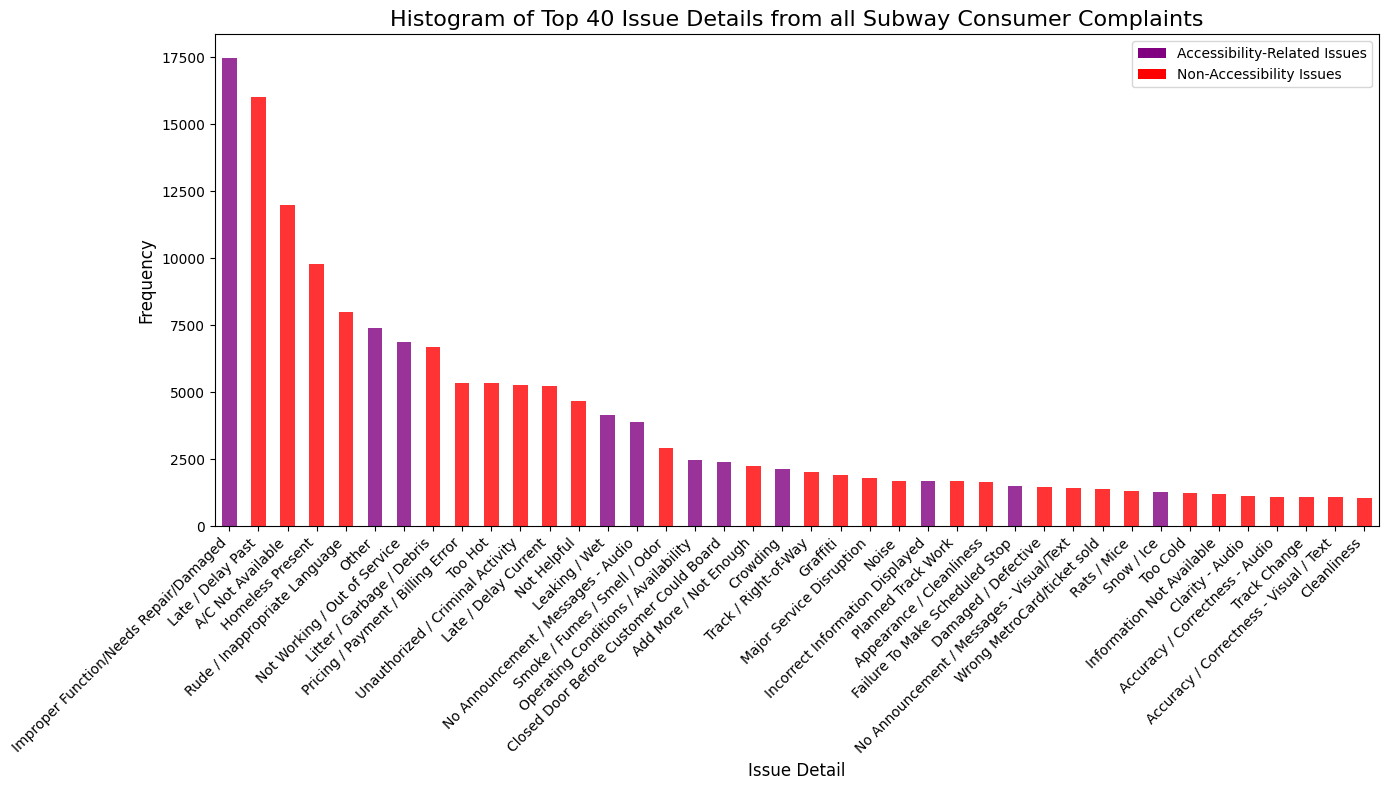

The histogram leaves out 15.23% of the total area.


In [ ]:
MTA_Feedback_Data_Issues = MTA_Feedback_Data['Issue Detail']

# Count the frequency of unique values in 'Issue Detail'
issue_detail_counts = MTA_Feedback_Data_Issues.value_counts()

# Select the top 40 unique values
top_40 = issue_detail_counts.head(40)

# Calculate the total area (count) of the remaining values left out
remaining_area = issue_detail_counts.iloc[40:].sum()
total_area = issue_detail_counts.sum()
percentage_left_out = (remaining_area / total_area) * 100  # Calculate percentage left out

# Define the list of accessibility-related issues
issue_list_Accessibility = [
    'Flagging / Failed To Stop',
    'Improper Function/Needs Repair/Damaged',
    'Other',
    'Failure To Make Scheduled Stop',
    'Not Working / Out of Service',
    'Closed Door Before Customer Could Board',
    'Crowding',
    'Abandoned Customer at Station/Stop',
    'No Announcement / Messages - Audio',
    'Leaking / Wet',
    'Bypassed Requested Stop',
    'Operating Conditions / Availability',
    'Caught In Closing Door',
    'Incorrect Information Displayed',
    'Terminated Route Early',
    'Snow / Ice'
]

# Create a list of colors based on whether the issue is in the accessibility list
bar_colors = ['purple' if issue in issue_list_Accessibility else 'red' for issue in top_40.index]

# Plot a histogram (bar plot) of the top 40 unique values with color coding
plt.figure(figsize=(14, 8))
top_40.plot(kind='bar', color=bar_colors, alpha=0.8)

# Customize the plot
plt.title('Histogram of Top 40 Issue Details from all Subway Consumer Complaints', fontsize=16)
plt.xlabel('Issue Detail', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better readability

# Add a custom legend with color patches
legend_elements = [
    Patch(facecolor='purple', label='Accessibility-Related Issues'),
    Patch(facecolor='red', label='Non-Accessibility Issues')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the histogram
plt.show()

# Print the percentage of the total area left out
print(f"The histogram leaves out {percentage_left_out:.2f}% of the total area.")

In [ ]:
# Save the DataFrame to a CSV file
final_filtered_dis_zip_dat_nyc.to_csv('disability_zipCodes_NYC.csv', index=False)
lat_long_zips = pd.read_csv('/content/mta-nyc-dataset/disability_zipCodes_NYC_geocodio_fd76b8ac9c6ad95bc46da979d7870cd66de6468d.csv')

In [ ]:
# Ensure that Latitude, Longitude, and Percent columns are numeric
lat_long_zips['Latitude'] = pd.to_numeric(lat_long_zips['Latitude'], errors='coerce')
lat_long_zips['Longitude'] = pd.to_numeric(lat_long_zips['Longitude'], errors='coerce')
lat_long_zips['Percent of population with an ambulatory disability'] = pd.to_numeric(
    lat_long_zips['Percent of population with an ambulatory disability'], errors='coerce'
)

# Filter rows with valid numeric values for Latitude, Longitude, and Percent
valid_data = lat_long_zips.dropna(subset=['Latitude', 'Longitude', 'Percent of population with an ambulatory disability'])

# Create a base map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Prepare data for the heat map
heat_data = [
    [row['Latitude'], row['Longitude'], row['Percent of population with an ambulatory disability']]
    for _, row in valid_data.iterrows()
]

# Add the HeatMap layer to the map
HeatMap(heat_data, radius=15).add_to(nyc_map)

# Save the map to an HTML file
map_filename = "nyc_heatmap.html"
nyc_map.save(map_filename)

# Display the heatmap directly in Colab
print("Displaying heatmap inline:")
IFrame(map_filename, width=700, height=500)

# # Optionally allow the user to download the file
# print("You can download the heatmap using the link below:")
# files.download(map_filename)


Displaying heatmap inline:


In [ ]:
nyc_map

WHAT: Here we make a heatmap of all of the ADA complient stations. The darker red, the higher the concentration

WHY: We can take this map and compare it with the heatmap of disability concentration above, and we can see if the needs are being met. There should a higher concentration of ADA stations where there is higher concentration of disabled individuals.



In [ ]:
filtered_stations_ADA = stations_ADA[['Line','Stop Name','Borough','Structure','GTFS Latitude','GTFS Longitude','ADA']]
# Borough, lat, long, and ADA for the plot...
filtered_stations_ADA = filtered_stations_ADA[filtered_stations_ADA['Borough'] != 'SI']

In [ ]:

# Extract coordinates and weights
heat_data = filtered_stations_ADA[['GTFS Latitude', 'GTFS Longitude', 'ADA']].values.tolist()

# Create a base map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add heat map overlay
HeatMap(data=heat_data, radius=20).add_to(nyc_map)

# Save or display the map
nyc_map.save("NYC_ADA_HeatMap_MAIN_FOR_ADA_COMPLIANT.html")
nyc_map

WHAT: Here we make a scatterplot of all of the ADA complient stations (Green) and we compare that to the non-ADA complient stations (Red)

WHY: We can take this map anbd compare it with the heatmap of disability concentration above, and we can see if the needs are being met. There should a higher concentration of ADA stations where there is higher concentration of disabled individuals. NOT USED. See Appendix

In [ ]:
# Create a base map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add scatter plot points to the map
for _, row in stations_ADA.iterrows():
    # Set the marker color based on ADA accessibility
    if row['ADA'] == 1:
        marker_color = 'green'  # Green for ADA accessible stations
    else:
        marker_color = 'red'    # Red for non-ADA accessible stations

    # Add a circle marker to the map
    folium.CircleMarker(
        location=[row['GTFS Latitude'], row['GTFS Longitude']],
        radius=5,                 # Size of the circle
        color=marker_color,       # Border color
        fill=True,
        fill_color=marker_color,  # Fill color
        fill_opacity=0.7,         # Transparency
        tooltip=row['Stop Name']  # Tooltip to show the Stop Name on hover
    ).add_to(nyc_map)

# Save the map to an HTML file
output_path = "scatter_plot_map.html"
nyc_map.save(output_path)

# Display the scatter plot map inline in Colab
print("Displaying scatter plot map inline:")
IFrame(output_path, width=700, height=500)

# Provide a download option for the HTML file
# print("You can download the scatter plot map using the link below:")
# files.download(output_path)
nyc_map

Displaying scatter plot map inline:


In [ ]:
#Replace borough abbreviations with full names
borough_names = {
    'Bx': 'Bronx',
    'Bk': 'Brooklyn',
    'M': 'Manhattan',
    'Q': 'Queens'
}

# Map the full names to the 'Borough' column
filtered_stations_ADA['Borough Full Name'] = filtered_stations_ADA['Borough'].map(borough_names)

# Calculate proportions
total_stations_by_borough = filtered_stations_ADA.groupby('Borough Full Name')['Stop Name'].count()

ada_1_proportion = (
    filtered_stations_ADA[filtered_stations_ADA['ADA'] == 1]
    .groupby('Borough Full Name')['Stop Name']
    .count() / total_stations_by_borough * 100
)

ada_1_2_proportion = (
    filtered_stations_ADA[filtered_stations_ADA['ADA'].isin([1, 2])]
    .groupby('Borough Full Name')['Stop Name']
    .count() / total_stations_by_borough * 100
)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# First Histogram: Proportion of ADA = 1 (fully accessible)
ada_1_proportion.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Fully ADA Accessible Stations (ADA = 1)')
axes[0].set_xlabel('Borough')
axes[0].set_ylabel('Percentage of Stations')
axes[0].set_xticklabels(ada_1_proportion.index, rotation=45)

# Add values on top of each bar for the first histogram
for i, value in enumerate(ada_1_proportion):
    axes[0].text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# Second Histogram: Proportion of ADA = 1 or 2 (fully or partially accessible)
ada_1_2_proportion.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Fully or Partially ADA Accessible Stations (ADA = 1 or 2)')
axes[1].set_xlabel('Borough')
axes[1].set_xticklabels(ada_1_2_proportion.index, rotation=45)

# Add values on top of each bar for the second histogram
for i, value in enumerate(ada_1_2_proportion):
    axes[1].text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'filtered_stations_ADA' is not defined

### References :

1. https://new.mta.info/accessibility/stations
2. https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-July-2020/wujg-7c2s/data_preview
3. https://data.ny.gov/Transportation/MTA-Subway-Turnstile-Usage-Data-2022/k7j9-jnct/data_preview

### Step-by-Step Tutorial to claim Kaggle API Token.

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

![](https://drive.google.com/uc?export=view&id=1xr0fWEnsP12D-NKKsuYKYoNwycmPMQHh)

![](https://drive.google.com/uc?export=view&id=1veUM5NvAR2Od90ETwtqMUij1LBcxNNoH)

![](https://drive.google.com/uc?export=view&id=1drD2OLEVe9VZMAr5sI2fDZ_KFTAy6jV1)